## Import libraries

In [1]:
import sqlite3
import urllib.request
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

## Load Dataset

#### Quick view of data
- The `.fetchall()` method retrieves the table name
- The `.head()` method offers a convenient preview of the first few rows

In [2]:
urllib.request.urlretrieve("https://techassessment.blob.core.windows.net/aiap19-assessment-data/agri.db", "agri.db")
conn = sqlite3.connect("agri.db")
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
print(cursor.fetchall())

[('farm_data',)]


- Initial observations:
    - Case variants present in Plant Type and Plant Stage 
    - Presence of a negative value in Temperature
    - Mixed units detected in Nutrient P

In [3]:
df = pd.read_sql_query("SELECT * FROM farm_data", conn)
df.head()

,System Location Code,Previous Cycle Plant Type,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,Water Level Sensor (mm)
0,Zone_D,Herbs,Vine Crops,Maturity,23.34,NaN,454.0,937,1.82,4,161,64,201,6.1,28.150346
1,Zone_G,Herbs,VINE CROPS,Vegetative,-24.16,63.14,441.0,938,2.13,6,161,53,None,6.5,31.000000
2,Zone_F,Herbs,herbs,maturity,23.84,NaN,562.0,1246,1.21,8,228,79,292,6.4,26.000000
3,Zone_G,Herbs,fruiting vegetables,Vegetative,22.61,NaN,651.0,1346,1.96,6,None,53 ppm,289,6.6,NaN
4,Zone_B,Vine Crops,LEAFY GREENS,seedling,22.88,NaN,144.0,812,2.76,5,61,19,168,5.5,28.000000


#### Features and data types
- The `.info()` method displays all the features and their data types
- Since Nutrient N, Nutrient P, and Nutrient K represent measurements, their data types should be numeric rather than object

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          57489 non-null  object 
 1   Previous Cycle Plant Type     57489 non-null  object 
 2   Plant Type                    57489 non-null  object 
 3   Plant Stage                   57489 non-null  object 
 4   Temperature Sensor (°C)       48800 non-null  float64
 5   Humidity Sensor (%)           18622 non-null  float64
 6   Light Intensity Sensor (lux)  53211 non-null  float64
 7   CO2 Sensor (ppm)              57489 non-null  int64  
 8   EC Sensor (dS/m)              57489 non-null  float64
 9   O2 Sensor (ppm)               57489 non-null  int64  
 10  Nutrient N Sensor (ppm)       47515 non-null  object 
 11  Nutrient P Sensor (ppm)       51791 non-null  object 
 12  Nutrient K Sensor (ppm)       53788 non-null  object 
 13  p

#### Descriptive statistics
- The `.describe()` method generates descriptive statistics for the dataset
- Negative values identified in Light Intensity, EC and Temperature are invalid due to the following reasons:
    - Light intensity: Represents the amount of light energy received per unit area. Since it's a measure of energy, it cannot be negative
    - Electrical conductivity (EC): Dependent on concentration of ions in the solution. Since ion concentration and conductivity are inherently non-negative, EC values cannot be negative
    - Temperature: The crops in the dataset (e.g., herbs, vine crops, leafy greens, fruiting vegetables) cannot naturally grow in sustained negative temperatures, making such values not biologically possible

In [5]:
df.describe()

,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),pH Sensor,Water Level Sensor (mm)
count,48800.000000,18622.000000,53211.000000,57489.000000,57489.000000,57489.000000,57489.000000,48847.000000
mean,22.138201,69.243535,397.841668,1083.376576,1.624435,6.580842,6.021446,25.716878
std,7.556981,5.725973,222.923860,172.570351,0.415535,1.145534,0.400251,5.815294
min,-28.570000,59.220000,-799.000000,799.000000,-0.250000,3.000000,3.800000,10.001955
25%,22.140000,64.340000,257.000000,950.000000,1.360000,6.000000,5.800000,21.313361
50%,23.210000,68.700000,403.000000,1071.000000,1.650000,7.000000,6.000000,26.000000
75%,24.350000,74.117500,553.000000,1178.000000,1.900000,7.000000,6.300000,30.000000
max,28.750000,81.140000,800.000000,1500.000000,3.440000,11.000000,7.800000,39.998717


## Data Cleaning

#### Define numerical and categorical features

In [6]:
num_col = [
    'Temperature Sensor (°C)',
    'Light Intensity Sensor (lux)',
    'Humidity Sensor (%)',
    'CO2 Sensor (ppm)',
    'EC Sensor (dS/m)',
    'O2 Sensor (ppm)',
    'Nutrient N Sensor (ppm)',
    'Nutrient P Sensor (ppm)',
    'Nutrient K Sensor (ppm)',
    'pH Sensor',
    'Water Level Sensor (mm)'
]

cat_col = [
    'System Location Code',
    'Previous Cycle Plant Type',
    'Plant Type',
    'Plant Stage'
]

#### Convert column types for Nutrients N, P, K
- Numeric types such as float64 are necessary for mathematical operations and statistical calculations
- Machine learning algorithms also require numeric inputs, as they rely on mathematical models to process data
- The `.astype()` method is used to convert object data types to float

In [7]:
for col in ['Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)']:
    df[col] = df[col].str.extract('(\d+)')
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('float')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57489 entries, 0 to 57488
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   System Location Code          57489 non-null  object 
 1   Previous Cycle Plant Type     57489 non-null  object 
 2   Plant Type                    57489 non-null  object 
 3   Plant Stage                   57489 non-null  object 
 4   Temperature Sensor (°C)       48800 non-null  float64
 5   Humidity Sensor (%)           18622 non-null  float64
 6   Light Intensity Sensor (lux)  53211 non-null  float64
 7   CO2 Sensor (ppm)              57489 non-null  int64  
 8   EC Sensor (dS/m)              57489 non-null  float64
 9   O2 Sensor (ppm)               57489 non-null  int64  
 10  Nutrient N Sensor (ppm)       47515 non-null  float64
 11  Nutrient P Sensor (ppm)       51791 non-null  float64
 12  Nutrient K Sensor (ppm)       53788 non-null  float64
 13  p

#### Handle negative values in Light Intensity, EC and Temperature
- Remove invalid negative values to ensure that the model is not trained on erroneous data
- Erroneous errors create noisy data, which distorts the relationships between the features and the target variable. This leads to poorer generalization to unseen data
- The row filtering method helps eliminate athe negative data points that may distort later analysis

In [8]:
df = df[(df['Temperature Sensor (°C)'] >= 0) & (df['Light Intensity Sensor (lux)'] >= 0) & (df['EC Sensor (dS/m)'] >= 0)]

- The `.describe()` method confirms that there are no more negative values 

In [9]:
df[['Temperature Sensor (°C)', 'Light Intensity Sensor (lux)', 'EC Sensor (dS/m)']].describe()

,Temperature Sensor (°C),Light Intensity Sensor (lux),EC Sensor (dS/m)
count,42860.000000,42860.000000,42860.000000
mean,23.337376,419.558959,1.623779
std,1.613244,178.750038,0.414931
min,18.930000,99.000000,0.010000
25%,22.240000,265.000000,1.360000
50%,23.270000,411.000000,1.640000
75%,24.390000,556.000000,1.890000
max,28.750000,800.000000,3.440000


#### Handle case variants
- Standardizing case eliminates variations, allowing the model to focus on the true underlying relationships between features instead of overfitting to case differences
- The `.unique()` method helps identify the unique categories within a column

In [10]:
cat_col = ['System Location Code', 'Previous Cycle Plant Type', 'Plant Type', 'Plant Stage']

for col in cat_col:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}':\n{unique_values}\n")

Unique values in 'System Location Code':
['Zone_D' 'Zone_F' 'Zone_G' 'Zone_B' 'Zone_C' 'Zone_A' 'Zone_E']

Unique values in 'Previous Cycle Plant Type':
['Herbs' 'Vine Crops' 'Leafy Greens' 'Fruiting Vegetables']

Unique values in 'Plant Type':
['Vine Crops' 'herbs' 'fruiting vegetables' 'LEAFY GREENS'
 'FRUITING VEGETABLES' 'Leafy Greens' 'Herbs' 'Fruiting Vegetables'
 'HERBS' 'vine crops' 'leafy greens' 'VINE CROPS']

Unique values in 'Plant Stage':
['Maturity' 'maturity' 'Vegetative' 'seedling' 'MATURITY' 'Seedling'
 'SEEDLING' 'VEGETATIVE' 'vegetative']



- Visualising clases with case variants
- Uneven distrbution of classes oabserved for Plant Type and Plant Stage

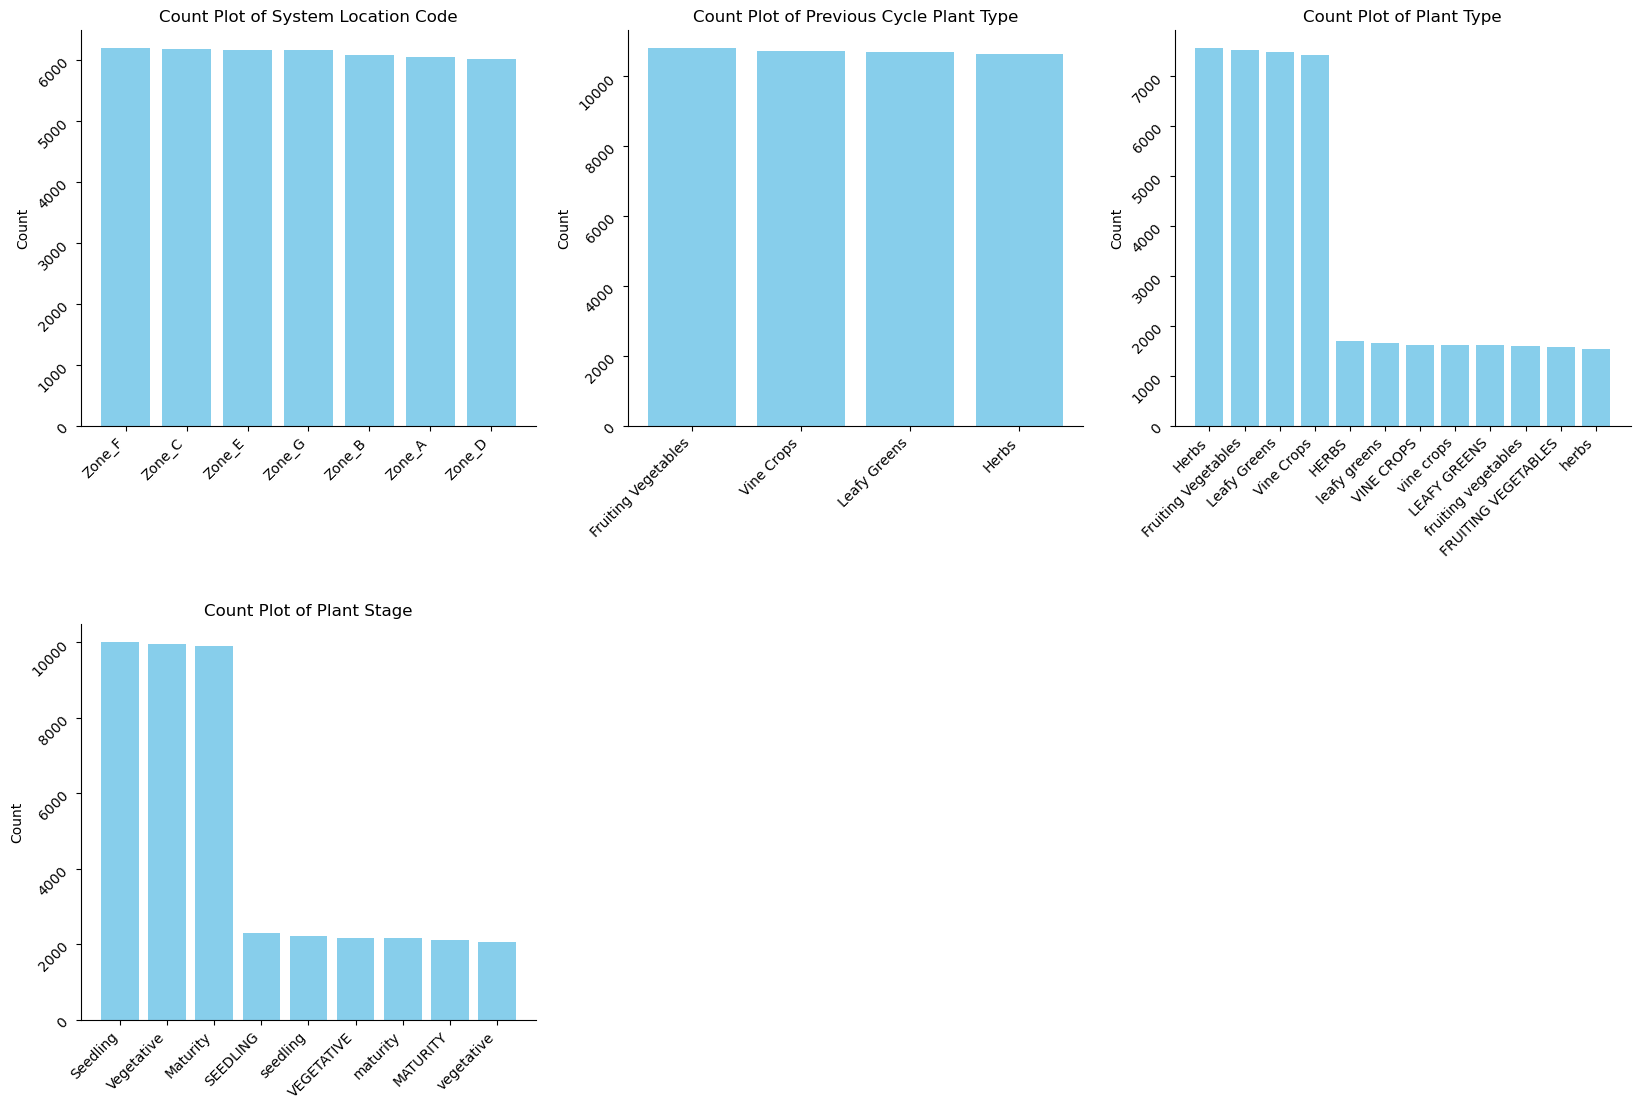

In [11]:
plt.figure(figsize=(20, 36))

for i, column in enumerate(cat_col):
    ax = plt.subplot(5, 3, i + 1)
    
    counts = df[column].value_counts()

    ax.bar(counts.index, counts.values, color='skyblue')
    ax.set_title(f'Count Plot of {column}')
    #ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(rotation=45)
    ax.set_xticks(range(len(counts.index)))
    ax.set_xticklabels(counts.index, ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots_adjust(hspace=0.5)
plt.show()

- The `.title()` method is used to standardize the formatting of category labels
- The `.unique()` method  confirms that case variants for Plant Type and Plant Stage have been removed

In [12]:
for col in ['Plant Type', 'Plant Stage']:
    df[col] = df[col].str.title()

for col in cat_col:
    unique_values = df[col].unique()
    print(f"Unique values in '{col}':\n{unique_values}\n")

Unique values in 'System Location Code':
['Zone_D' 'Zone_F' 'Zone_G' 'Zone_B' 'Zone_C' 'Zone_A' 'Zone_E']

Unique values in 'Previous Cycle Plant Type':
['Herbs' 'Vine Crops' 'Leafy Greens' 'Fruiting Vegetables']

Unique values in 'Plant Type':
['Vine Crops' 'Herbs' 'Fruiting Vegetables' 'Leafy Greens']

Unique values in 'Plant Stage':
['Maturity' 'Vegetative' 'Seedling']



- Visualising the class distribution after standardizing case variants
- An even distribution of classes is observed across all categorical features

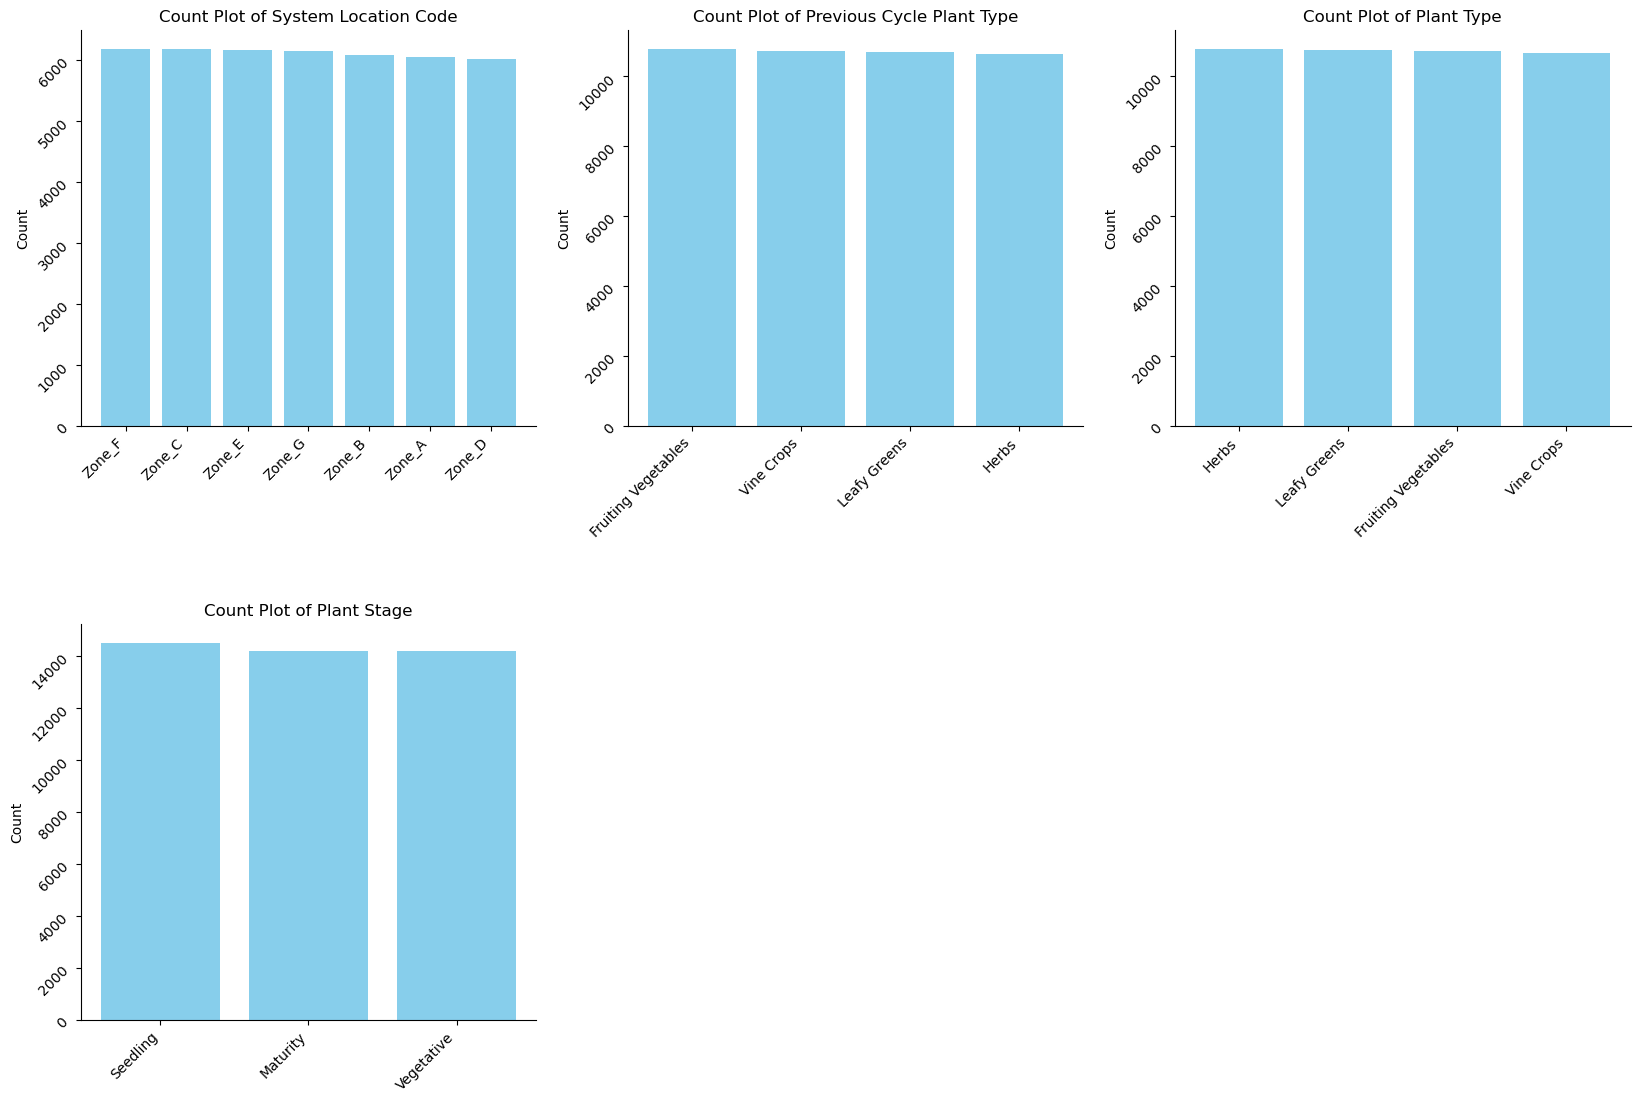

In [13]:
plt.figure(figsize=(20, 36))

for i, column in enumerate(cat_col):
    ax = plt.subplot(5, 3, i + 1)
    
    counts = df[column].value_counts()

    ax.bar(counts.index, counts.values, color='skyblue')
    ax.set_title(f'Count Plot of {column}')
    #ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(rotation=45)
    ax.set_xticks(range(len(counts.index)))
    ax.set_xticklabels(counts.index, ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots_adjust(hspace=0.5)
plt.show()

#### Create the Plant Type-Stage variable
- Feature concatenation combines the Plant Type and Plant Stage features into a single new variable for classification
- The `.head()` method displays that the Plant Type-Stage variable has been successfully created

In [14]:
df['Plant Type-Stage'] = df['Plant Type'] + '-' + df['Plant Stage']
print(df[['Plant Type', 'Plant Stage', 'Plant Type-Stage']].head())

            Plant Type Plant Stage                Plant Type-Stage
0           Vine Crops    Maturity             Vine Crops-Maturity
2                Herbs    Maturity                  Herbs-Maturity
3  Fruiting Vegetables  Vegetative  Fruiting Vegetables-Vegetative
4         Leafy Greens    Seedling           Leafy Greens-Seedling
5  Fruiting Vegetables    Maturity    Fruiting Vegetables-Maturity


- Visualising the class distribution of the newly created Plant Type-Stage variable
- An even distribution of classes is observed for the Plant Type-Stage variable

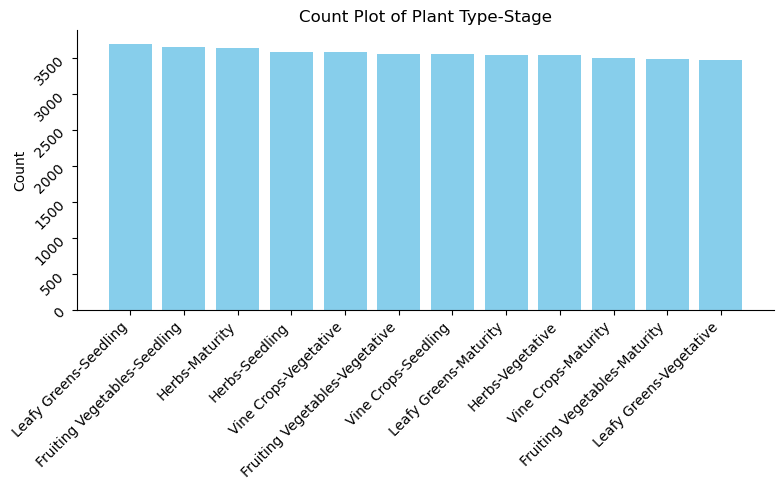

In [15]:
plt.figure(figsize=(8, 5))

column_name = 'Plant Type-Stage'

counts = df[column_name].value_counts()

ax = plt.subplot(1, 1, 1)

ax.bar(counts.index, counts.values, color='skyblue')
ax.set_title(f'Count Plot of {column_name}')
ax.set_ylabel('Count')
ax.tick_params(rotation=45)
ax.set_xticks(counts.index)
ax.set_xticklabels(counts.index, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

#### Handle missing values
- Small portion of missing data:
    - Dropping rows with missing data is acceptable because the loss of information is minimal
    - Simple imputation methods (e.g., mean, median) work well because they don't significantly alter the data structure
- Large portion of missing data:
    - Dropping the entire column can lead to a significant loss of information, particularly if the feature has predictive value
    - Imputation becomes necessary to preserve this information
- Type of Missingness:
    - MCAR (Missing Completely At Random):
        - Simple imputation is suitable because the missingness is random and not related to any feature or the target
        - This minimizes the risk of introducing bias
    - MAR (Missing At Random) and MNAR (Missing Not At Random):
        - Simple imputation can introduce bias because the missingness is related to other variables (MAR) or to the variable itself (MNAR)
        - Advanced imputation techniques like KNN, model-based imputation (e.g., Random Forest, regression), or even deep learning methods are preferred as they consider relationships in the data and help preserve its structure and predictive power
- Impact of missing data:
    - Loss of information by dropping significant number of rows or entire columns can impair the model’s ability to generalize, resulting in poorer performance on unseen data
    - Introduction of bias by improper handling of MAR or MNAR missingness can distort relationships within the data, leading to systematic prediction errors, where the model fails to capture the true patterns in the data
- The `.isna().sum()` method helps identify and count the number of missing values

In [16]:
df.isna().sum()

System Location Code                0
Previous Cycle Plant Type           0
Plant Type                          0
Plant Stage                         0
Temperature Sensor (°C)             0
Humidity Sensor (%)             28990
Light Intensity Sensor (lux)        0
CO2 Sensor (ppm)                    0
EC Sensor (dS/m)                    0
O2 Sensor (ppm)                     0
Nutrient N Sensor (ppm)          7435
Nutrient P Sensor (ppm)          4284
Nutrient K Sensor (ppm)          2723
pH Sensor                           0
Water Level Sensor (mm)          6423
Plant Type-Stage                    0
dtype: int64

- The Humidity Sensor (%) feature has a large portion of missing data
- The correlation coefficient of 0.3 with Temperature indicates some predictive value, so it's better to retain the feature to avoid losing potentially useful information
- If the correlation coefficient were close to 0, it would suggest minimal predictive value, and the feature could be dropped without significant impact

In [17]:
correlation = df['Humidity Sensor (%)'].corr(df['Temperature Sensor (°C)'])

print("Correlation coefficient between Humidity Sensor (%) and Temperature Sensor (°C):", correlation)

Correlation coefficient between Humidity Sensor (%) and Temperature Sensor (°C): 0.30231941373176685


- A correlation coefficient of 0.3 is relatively high between Humidity and Temperature compared to other features in the correlation matrix
- This further justifies retaining the feature to preserve valuable information for the model

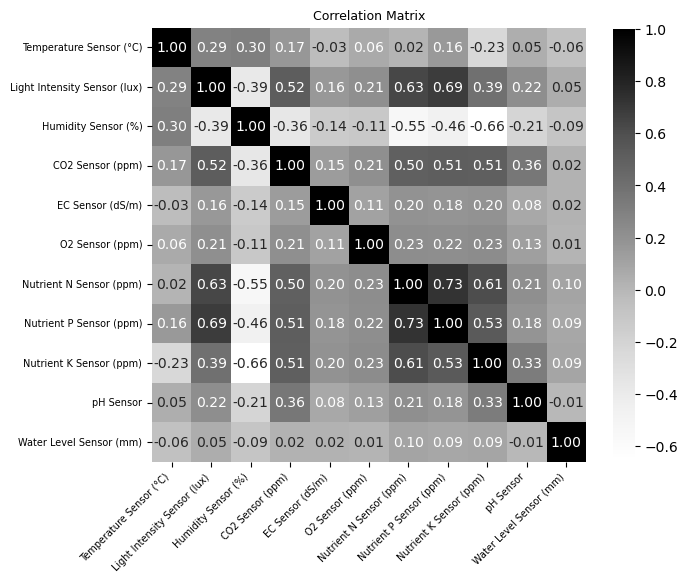

In [18]:
correlation_matrix = df[num_col].corr()
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Greys', square=True, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix', fontsize=9)
plt.xticks(rotation=45, fontsize=7, ha='right')
plt.yticks(fontsize=7)
plt.show()

- The type of missingness in Humidity Sensor is MCAR (Missing Completely at Random) because the proportion of missing data is even across the bins and categories of other features
- Simple imputation strategies like mean or median are unlikely to introduce biases
- If the missingness is instead MAR (Missing at Random) or MNAR (Missing Not at Random), imputing with simple strategies might introduce significant biases, then advanced imputation methods like KNN or model-based is preferred

- Visualising the proportion of missing data across bins in Temperature

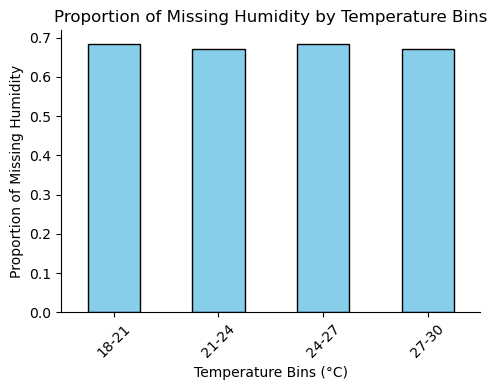

In [19]:
df['missing_humidity'] = df['Humidity Sensor (%)'].isna()
bins = [18, 21, 24, 27, 30]
labels = ['18-21', '21-24', '24-27', '27-30']
df['temp_bins'] = pd.cut(df['Temperature Sensor (°C)'], bins=bins, labels=labels, right=False)

# Calculate the proportion of missing humidity values in each bin
missing_by_bins = df.groupby('temp_bins')['missing_humidity'].mean()

plt.figure(figsize=(5, 4))
missing_by_bins.plot(kind='bar', color='skyblue', edgecolor='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Proportion of Missing Humidity by Temperature Bins')
plt.xlabel('Temperature Bins (°C)')
plt.ylabel('Proportion of Missing Humidity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Visualising the proportion of missing data across bins in Light Intensity

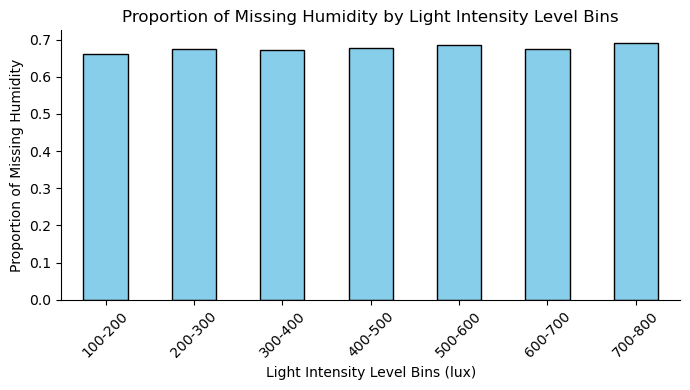

In [20]:
df['missing_humidity'] = df['Humidity Sensor (%)'].isna()
bins = [100, 200, 300, 400, 500, 600, 700, 800]
labels = ['100-200', '200-300', '300-400', '400-500', '500-600', '600-700', '700-800']
df['light_bins'] = pd.cut(df['Light Intensity Sensor (lux)'], bins=bins, labels=labels, right=False)

# Calculate the proportion of missing humidity values in each bin
missing_by_bins = df.groupby('light_bins')['missing_humidity'].mean()

plt.figure(figsize=(7, 4))
missing_by_bins.plot(kind='bar', color='skyblue', edgecolor='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Proportion of Missing Humidity by Light Intensity Level Bins')
plt.xlabel('Light Intensity Level Bins (lux)')
plt.ylabel('Proportion of Missing Humidity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Visualising the proportion of missing data across bins in CO2

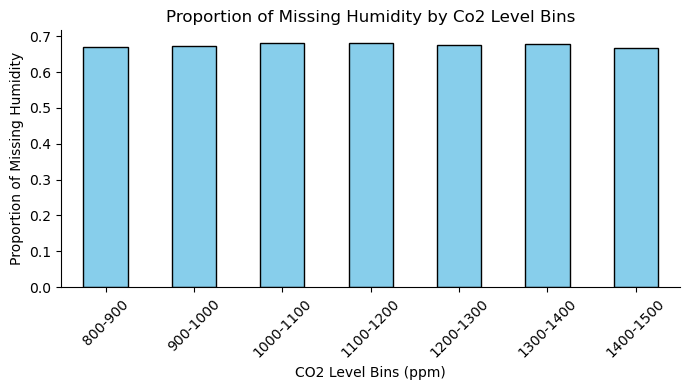

In [21]:
df['missing_humidity'] = df['Humidity Sensor (%)'].isna()
bins = [800, 900, 1000, 1100, 1200, 1300, 1400, 1500]
labels = ['800-900', '900-1000', '1000-1100', '1100-1200', '1200-1300', '1300-1400', '1400-1500']
df['co2_bins'] = pd.cut(df['CO2 Sensor (ppm)'], bins=bins, labels=labels, right=False)

# Calculate the proportion of missing humidity values in each bin
missing_by_bins = df.groupby('co2_bins')['missing_humidity'].mean()

plt.figure(figsize=(7, 4))
missing_by_bins.plot(kind='bar', color='skyblue', edgecolor='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Proportion of Missing Humidity by Co2 Level Bins')
plt.xlabel('CO2 Level Bins (ppm)')
plt.ylabel('Proportion of Missing Humidity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Visualising the proportion of missing data across bins in EC

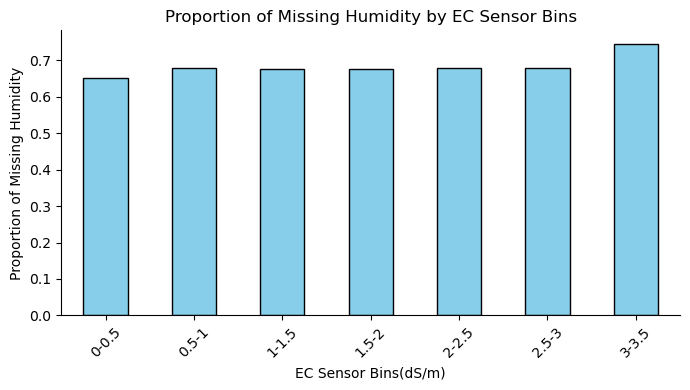

In [22]:
df['missing_humidity'] = df['Humidity Sensor (%)'].isna()
bins = [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]
labels = ['0-0.5', '0.5-1', '1-1.5', '1.5-2', '2-2.5', '2.5-3', '3-3.5']
df['ec_bins'] = pd.cut(df['EC Sensor (dS/m)'], bins=bins, labels=labels, right=False)

# Calculate the proportion of missing humidity values in each bin
missing_by_bins = df.groupby('ec_bins')['missing_humidity'].mean()

plt.figure(figsize=(7, 4))
missing_by_bins.plot(kind='bar', color='skyblue', edgecolor='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Proportion of Missing Humidity by EC Sensor Bins')
plt.xlabel('EC Sensor Bins(dS/m)')
plt.ylabel('Proportion of Missing Humidity')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Visualising the proportion of missing data for each class in Plant Type

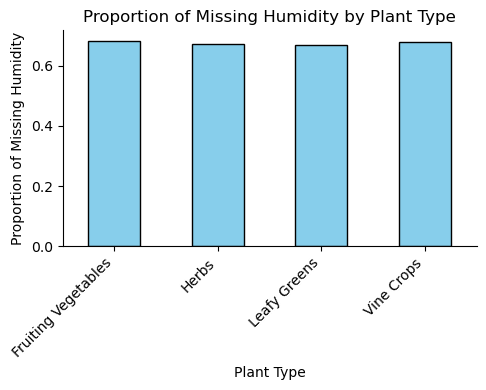

In [23]:
df['missing_humidity'] = df['Humidity Sensor (%)'].isna()
df['Plant Type category'] = df['Plant Type'].astype('category')

# Calculate the proportion of missing humidity values in each bin
missing_by_bins = df.groupby('Plant Type category')['missing_humidity'].mean()

plt.figure(figsize=(5, 4))
missing_by_bins.plot(kind='bar', color='skyblue', edgecolor='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Proportion of Missing Humidity by Plant Type')
plt.xlabel('Plant Type')
plt.ylabel('Proportion of Missing Humidity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Visualising the proportion of missing data for each class in Plant Stage

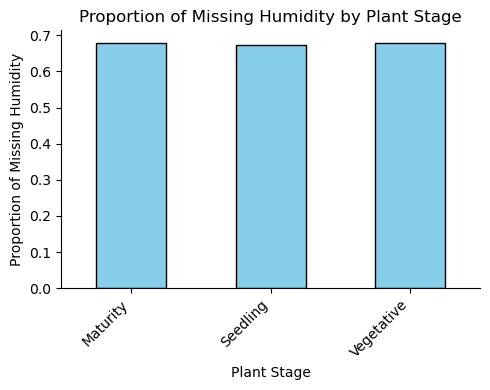

In [24]:
df['missing_humidity'] = df['Humidity Sensor (%)'].isna()
df['Plant Stage category'] = df['Plant Stage'].astype('category')

# Calculate the proportion of missing humidity values in each bin
missing_by_bins = df.groupby('Plant Stage category')['missing_humidity'].mean()

plt.figure(figsize=(5, 4))
missing_by_bins.plot(kind='bar', color='skyblue', edgecolor='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Proportion of Missing Humidity by Plant Stage')
plt.xlabel('Plant Stage')
plt.ylabel('Proportion of Missing Humidity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Visualising the proportion of missing data for each class in Plant Type-Stage

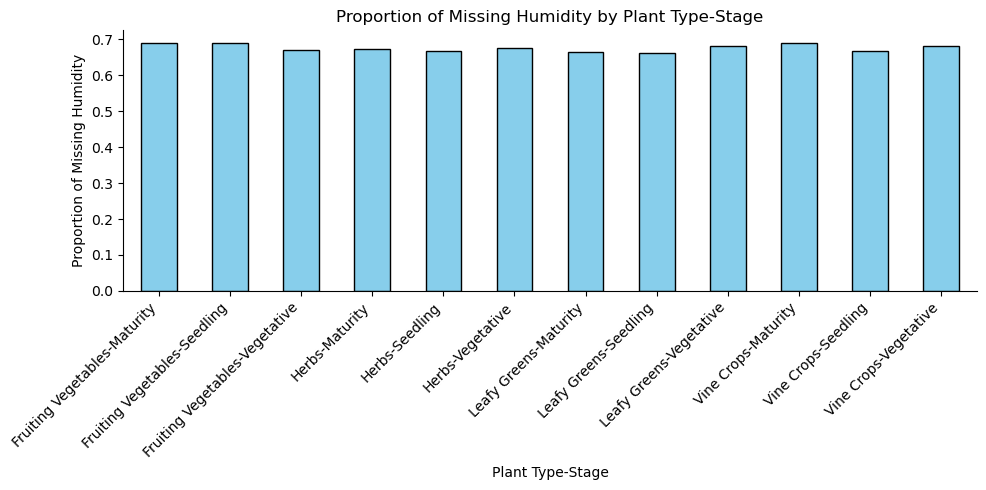

In [25]:
df['missing_humidity'] = df['Humidity Sensor (%)'].isna()
df['Plant Type-Stage category'] = df['Plant Type-Stage'].astype('category')

# Calculate the proportion of missing humidity values in each bin
missing_by_bins = df.groupby('Plant Type-Stage category')['missing_humidity'].mean()

plt.figure(figsize=(10, 5))
missing_by_bins.plot(kind='bar', color='skyblue', edgecolor='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Proportion of Missing Humidity by Plant Type-Stage')
plt.xlabel('Plant Type-Stage')
plt.ylabel('Proportion of Missing Humidity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- Visualising the proportion of missing data for each class in System Location Code

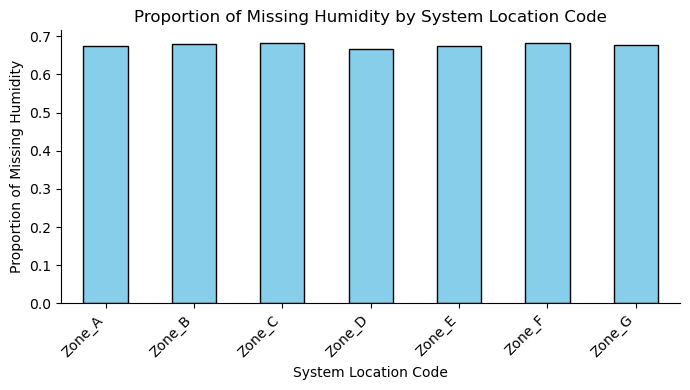

In [26]:
df['missing_humidity'] = df['Humidity Sensor (%)'].isna()
df['System Location Code category'] = df['System Location Code'].astype('category')

# Calculate the proportion of missing humidity values in each bin
missing_by_bins = df.groupby('System Location Code category')['missing_humidity'].mean()

plt.figure(figsize=(7, 4))
missing_by_bins.plot(kind='bar', color='skyblue', edgecolor='black')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Proportion of Missing Humidity by System Location Code')
plt.xlabel('System Location Code')
plt.ylabel('Proportion of Missing Humidity')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

- The distribution of the Humidity Sensor (%) feature is slightly right-skewed
- If the distribution were normal, simple imputation would generally be the preferred method, as it would provide an accurate average estimate due to the symmetry of the data
- However, given the skewed distribution, modle-based imputation is a better choice as it helps preserve the underlying structure of the data more effectively

- Visualising the distribution of Humidity Sensor (%)

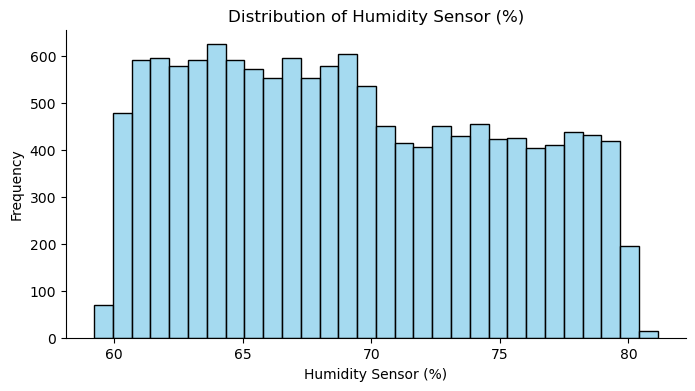

In [27]:
plt.figure(figsize=(8, 4))
sns.histplot(df['Humidity Sensor (%)'], kde=False, color='skyblue', bins=30)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Distribution of Humidity Sensor (%)')
plt.xlabel('Humidity Sensor (%)')
plt.ylabel('Frequency')
plt.show()

- Applying the `RandomForestRegressor` for advanced imputation to Humidity Sensor (%)
- The `.isna().sum()` method confirms the removal of missing values

Humidity Sensor (%)    0
dtype: int64


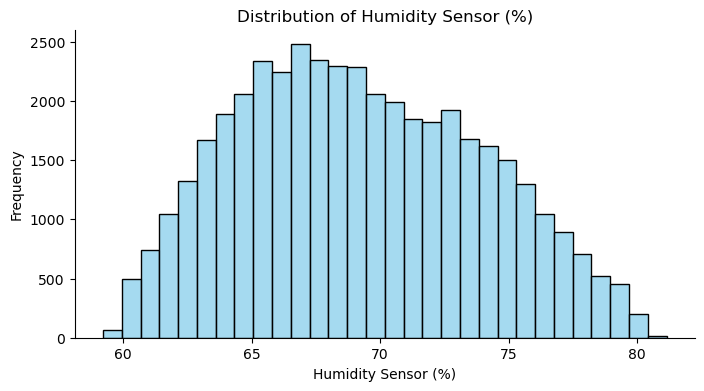

In [28]:
from sklearn.ensemble import RandomForestRegressor

observed = df[df['Humidity Sensor (%)'].notna()]
missing = df[df['Humidity Sensor (%)'].isna()]

rf = RandomForestRegressor(n_estimators=200, random_state=0)
rf.fit(observed.index.values.reshape(-1, 1), observed['Humidity Sensor (%)'])

df.loc[df['Humidity Sensor (%)'].isna(), 'Humidity Sensor (%)'] = rf.predict(missing.index.values.reshape(-1, 1))

print(df[['Humidity Sensor (%)']].isna().sum())

plt.figure(figsize=(8, 4))
sns.histplot(df['Humidity Sensor (%)'], kde=False, color='skyblue', bins=30)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.title('Distribution of Humidity Sensor (%)')
plt.xlabel('Humidity Sensor (%)')
plt.ylabel('Frequency')
plt.show()

- The Nutrient N Sensor (ppm), Nutrient P Sensor (ppm), Nutrient K Sensor (ppm), and Water Level Sensor (mm) features have a small proportion of missing data
- In general, simple imputation can be effective for preserving the overall structure of the dataset without significantly affecting its integrity
- However, given the varying distribution characteristics of these features, KNN or model-based imputation is recommended to better preserve the underlying data structure.
    - The distributions for the Nutrient N Sensor (ppm), Nutrient P Sensor (ppm), and Nutrient K Sensor (ppm) are multimodal, indicating that simple imputation may not capture the complexity of these features
    - The distribution for the Water Level Sensor (mm) is slightly right-skewed, suggesting that model-based imputation can better handle the asymmetry and maintain the data's integrity

- Visualising the distribution of Nutrient N Sensor (ppm), Nutrient P Sensor (ppm), Nutrient K Sensor (ppm), and Water Level Sensor (mm)

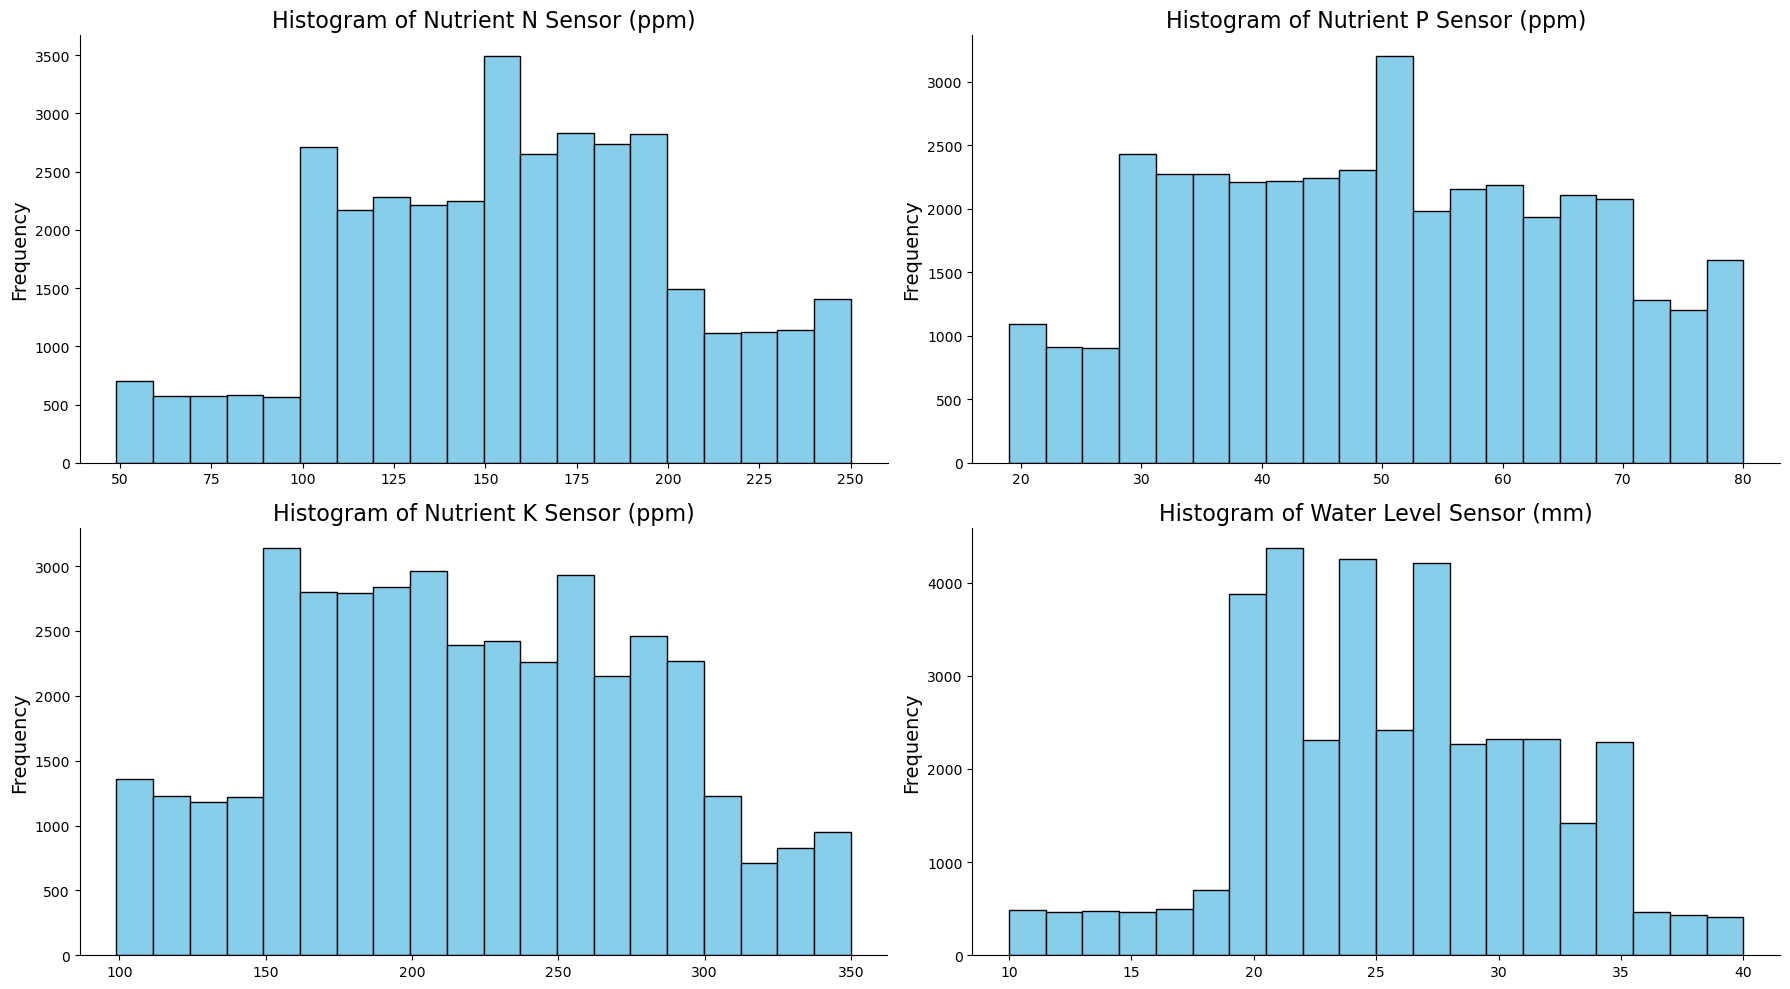

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

axs = axs.flatten()

columns_to_plot = ['Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)', 'Water Level Sensor (mm)']

for i, col in enumerate(columns_to_plot):
    axs[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Histogram of {col}', fontsize=16)
    axs[i].set_ylabel('Frequency', fontsize=14)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

for j in range(len(columns_to_plot), len(axs)):
    axs[j].remove()

plt.tight_layout()
plt.show()

- Utilizing the `KNNImputer` module for advanced imputation
- The `.isna().sum()` method confirms the removal of missing values

In [30]:
from sklearn.impute import KNNImputer

columns_to_impute = ['Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)', 'Water Level Sensor (mm)']

imputer = KNNImputer(n_neighbors=5)
df[columns_to_impute] = imputer.fit_transform(df[columns_to_impute])

print(df[columns_to_impute].isna().sum())

Nutrient N Sensor (ppm)    0
Nutrient P Sensor (ppm)    0
Nutrient K Sensor (ppm)    0
Water Level Sensor (mm)    0
dtype: int64


- Reassess the distributions of Nutrient N Sensor (ppm), Nutrient P Sensor (ppm), Nutrient K Sensor (ppm), and Water Level Sensor (mm) after imputation to observe any changes

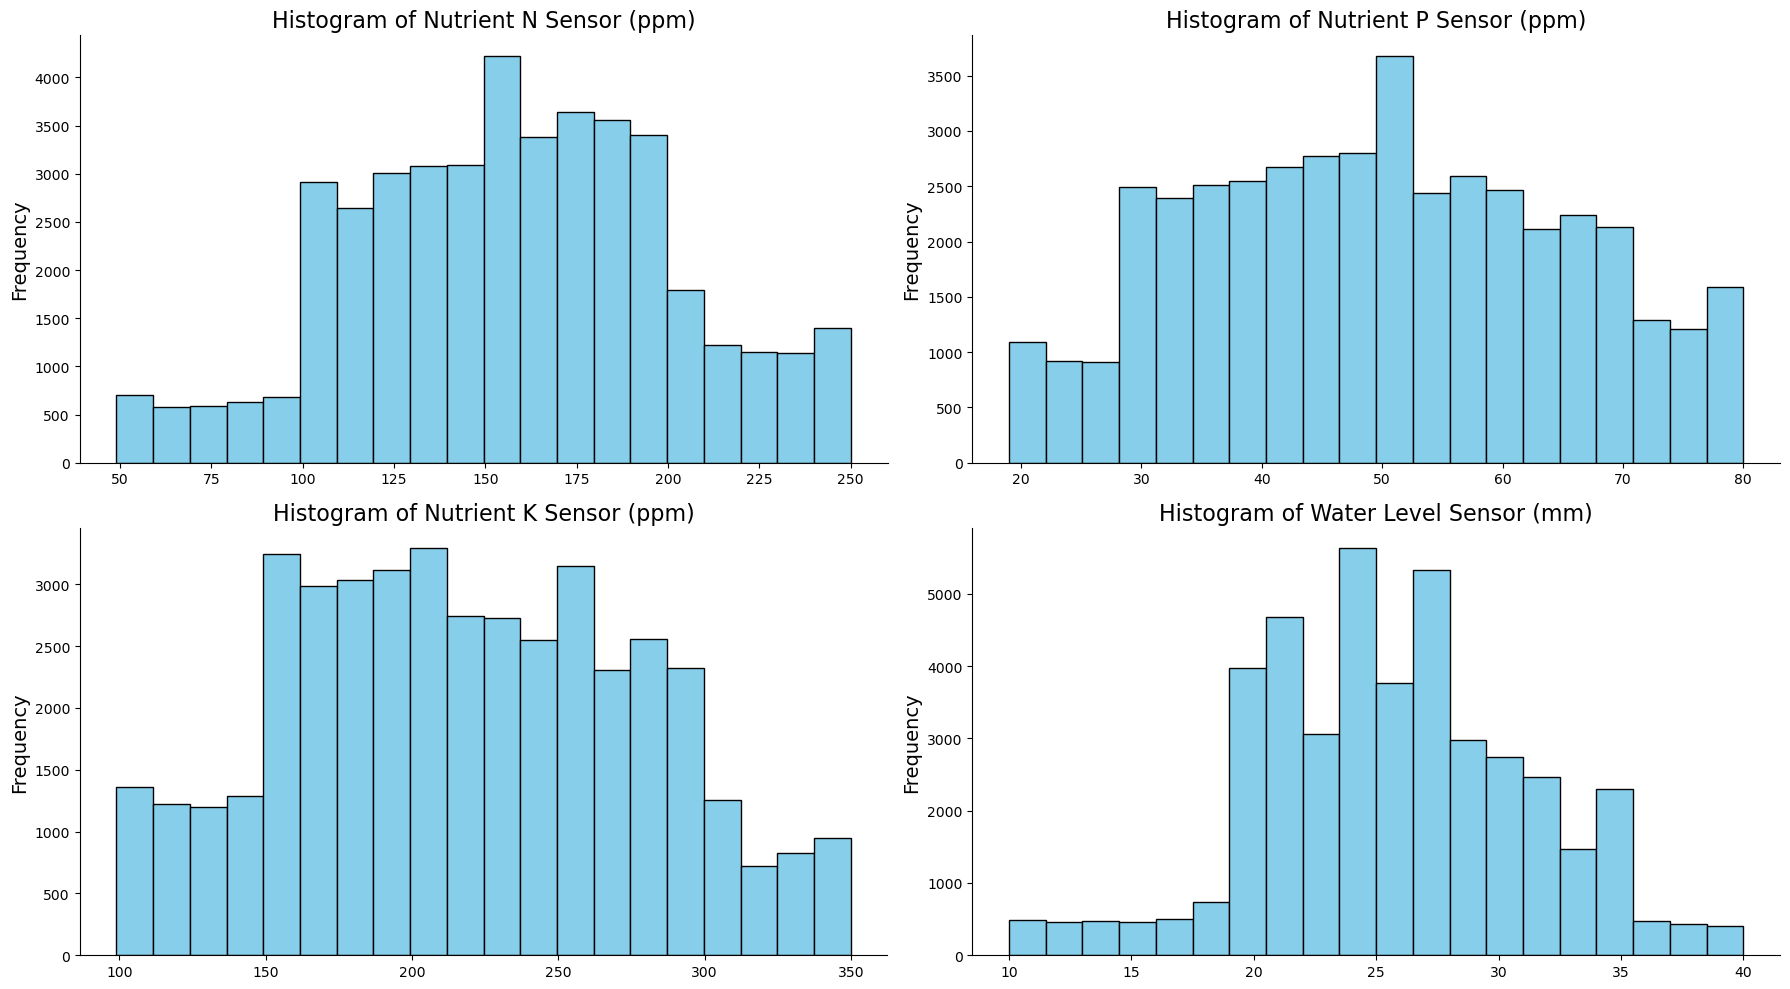

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(18, 10))

axs = axs.flatten()

columns_to_plot = ['Nutrient N Sensor (ppm)', 'Nutrient P Sensor (ppm)', 'Nutrient K Sensor (ppm)', 'Water Level Sensor (mm)']

for i, col in enumerate(columns_to_plot):
    axs[i].hist(df[col], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Histogram of {col}', fontsize=16)
    axs[i].set_ylabel('Frequency', fontsize=14)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

for j in range(len(columns_to_plot), len(axs)):
    axs[j].remove()

plt.tight_layout()
plt.show()

#### Handle duplicate rows
- Removing duplicate rows:
    - Prevents overrepresentation of data, which can skew model learning and cause overfitting
    - Ensures the model learns a balanced representation of the data, improving its performance on unseen data
- The `.duplicated()` method identifies duplicate rows
- The `.shape` attribute reveals duplicate data exists

In [32]:
duplicate_rows_df = df[df.duplicated()]
duplicate_rows_df.shape

(2831, 25)

- The number of duplicated rows is very small

In [33]:
duplicated_rows = duplicate_rows_df.shape[0]
total_rows = df.shape[0]
print(f"Proportion of duplicated rows: {duplicated_rows / total_rows:.4f}")

Proportion of duplicated rows: 0.0661


- The `drop_duplicates()` method removes duplicate rows
- The `.shape` attribute confirms that the duplicate rows have been removed

In [34]:
df = df.drop_duplicates()
df.shape

(40029, 25)

#### Handle outliers
- Outliers:
    - Disproportionately influence model parameters, leading to biased or inaccurate predictions. In linear regression for example, outliers can heavily skew the coefficients, reducing the model's overall accuracy and reliability
    - Might represent rare, exceptional cases that are not reflective of the overall data distribution. Removing these points helps the model focus on patterns that are more likely to generalize to unseen data, improving the model's predictive performance
- The `.boxplot()` method detects outliers

- Visualising outliers
    - Outliers are observed in Temperature, EC, O2, pH, and Water Level

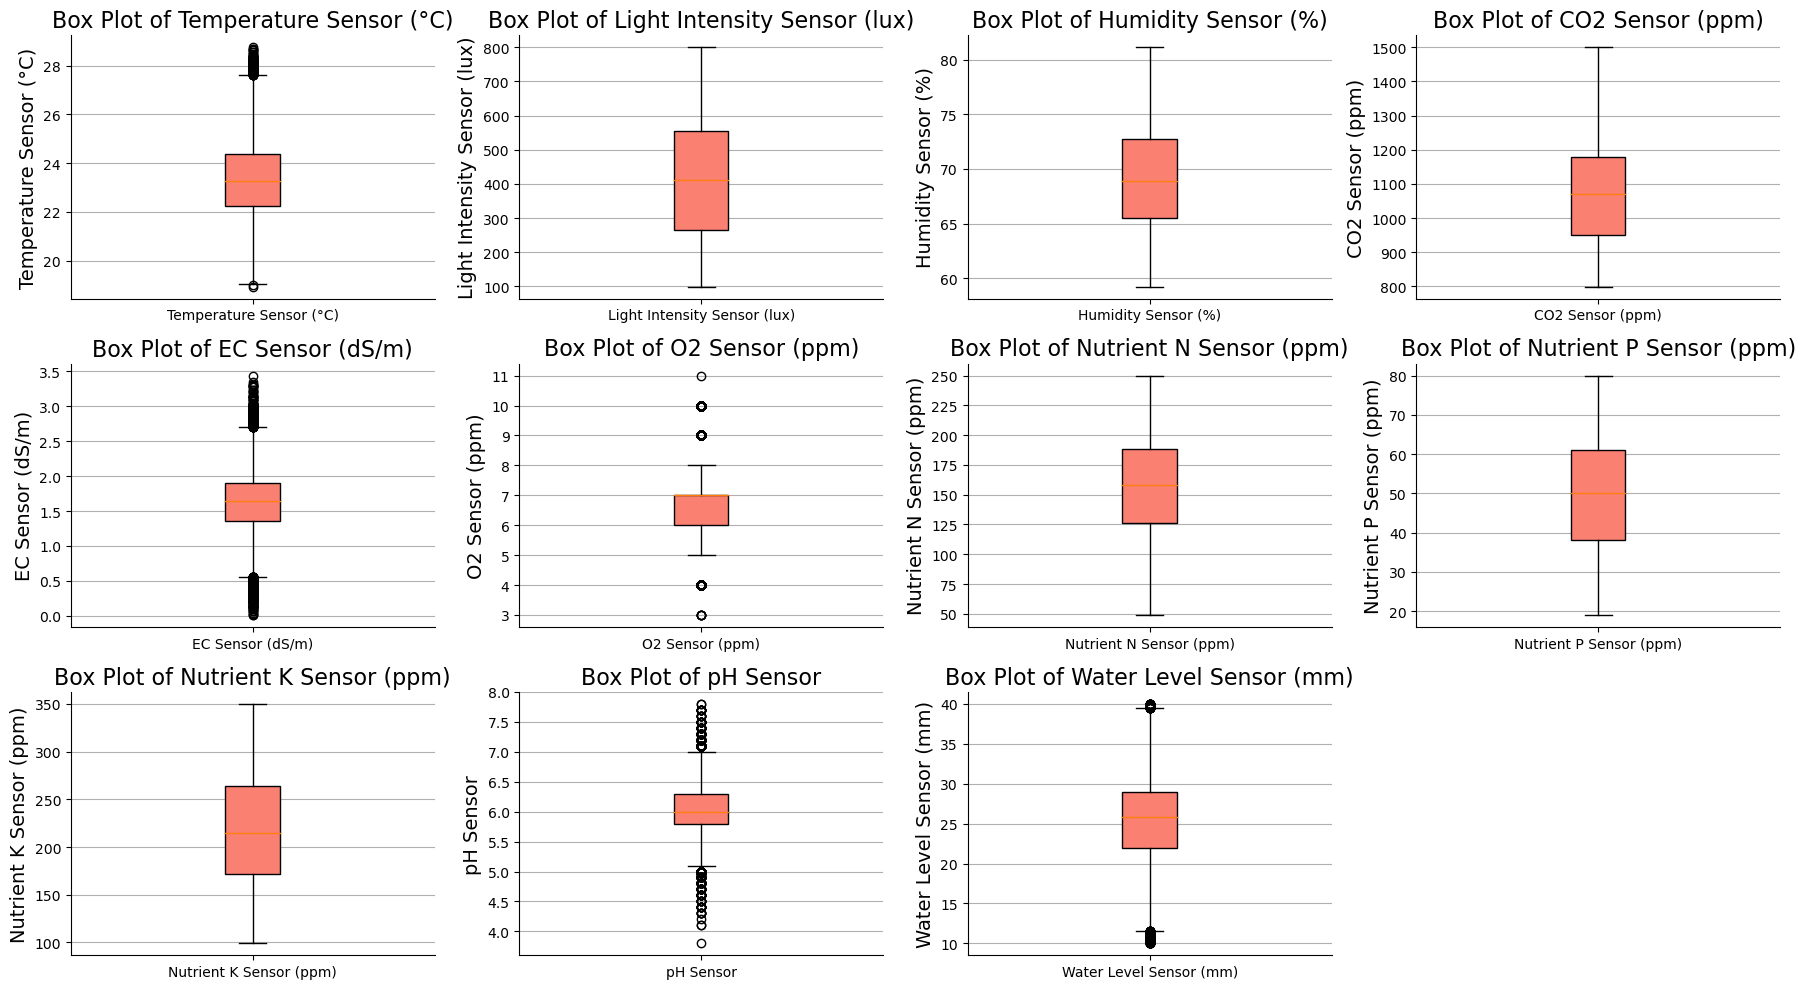

In [35]:
fig, axs = plt.subplots(3, 4, figsize=(18, 10))

axs = axs.flatten()
            
for i in range(len(num_col)):

    axs[i].boxplot(df[num_col[i]], vert=True, patch_artist=True, boxprops=dict(facecolor='salmon'))
    axs[i].set_title(f'Box Plot of {num_col[i]}', fontsize=16)
    axs[i].set_ylabel(num_col[i], fontsize=14)
    axs[i].set_xticklabels([num_col[i]])
    axs[i].grid(axis='y')
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

for j in range(len(num_col), len(axs)):
    axs[j].remove()
    
plt.tight_layout()
plt.show()

- Investigating outliers in Temperature:
    - The consistent presence of outliers across zones suggests they may be naturally occurring
    - Notably, the maximum temperature values for the Fruiting Vegetables-Maturity class are significantly higher compared to other classes, contributing to the outliers
    - Similarly, the minimum temperature values for the Leafy Greens-Maturity and Leafy Greens-Vegetative classes are considerably lower than those of other classes, further contributing to the outliers
    - Additional information or domain expertise is required to determine whether these exceptional temperature ranges are valid. Until such confirmation is available, retaining the data is advisable

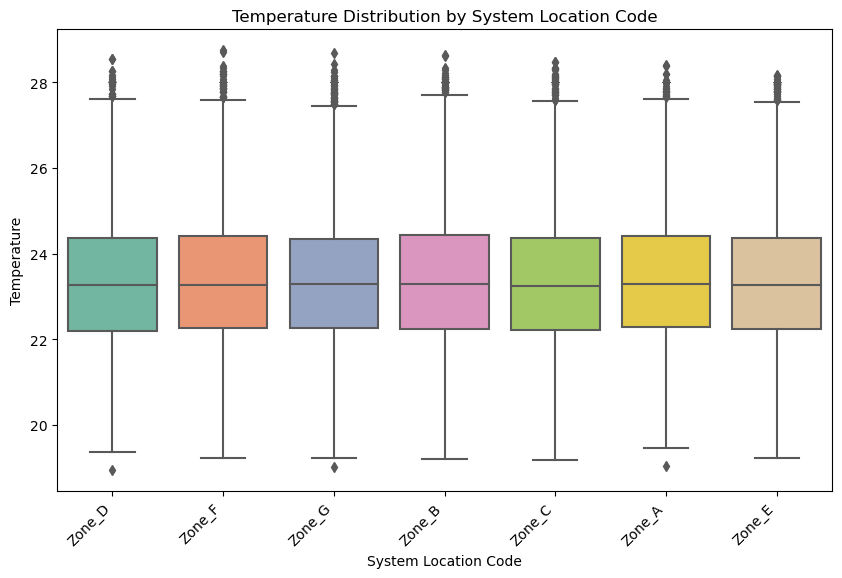

In [36]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='System Location Code', y='Temperature Sensor (°C)', palette='Set2')
plt.title('Temperature Distribution by System Location Code')
plt.xlabel('System Location Code')
plt.ylabel('Temperature')
plt.xticks(rotation=45, ha='right')
plt.show()

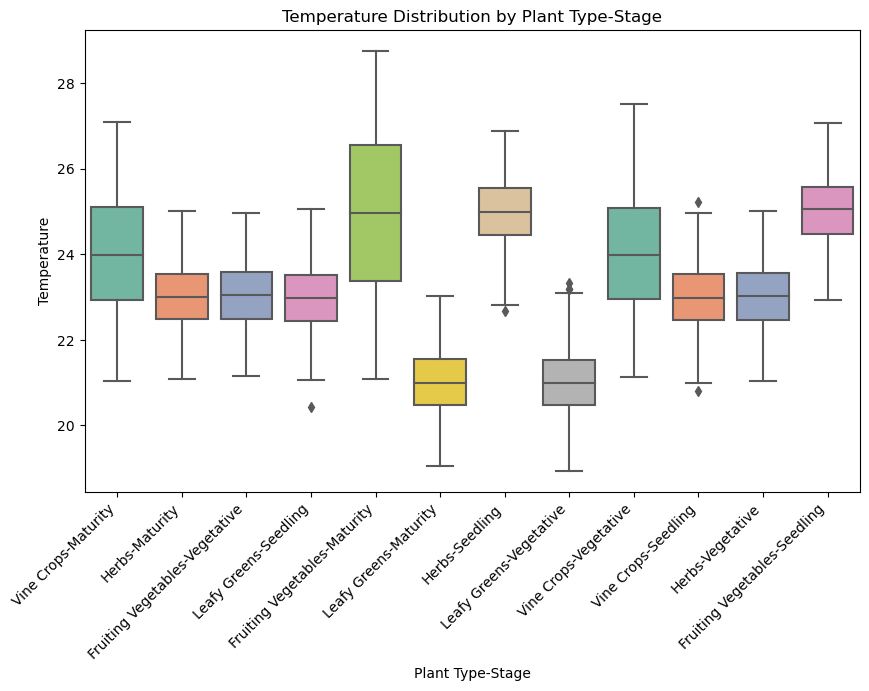

In [37]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Plant Type-Stage', y='Temperature Sensor (°C)', palette='Set2')
plt.title('Temperature Distribution by Plant Type-Stage')
plt.xlabel('Plant Type-Stage')
plt.ylabel('Temperature')
plt.xticks(rotation=45, ha='right')
plt.show()

- Investigating outliers in EC
    - The consistent occurrence of outliers across zones and Plant Type-Stage indicates they are likely naturally occurring and do not warrant removal

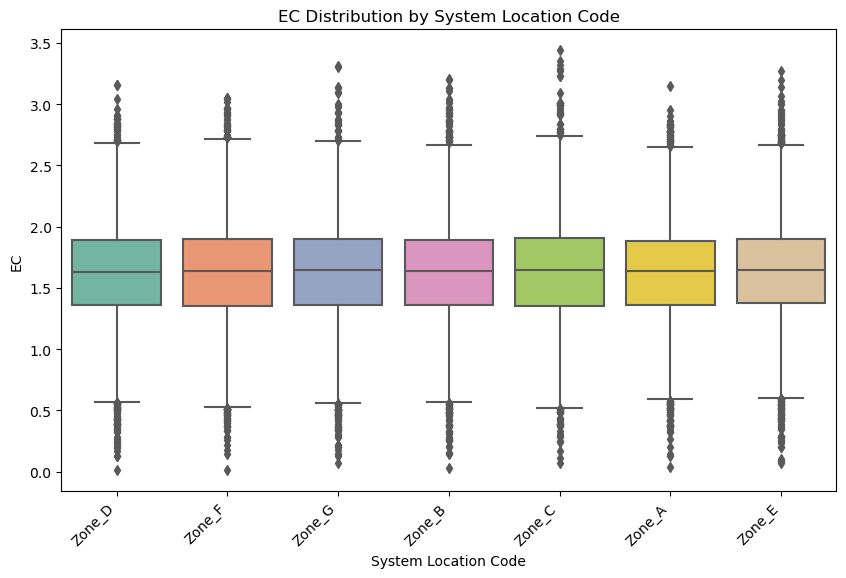

In [38]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='System Location Code', y='EC Sensor (dS/m)', palette='Set2')
plt.title('EC Distribution by System Location Code')
plt.xlabel('System Location Code')
plt.ylabel('EC')
plt.xticks(rotation=45, ha='right')
plt.show()

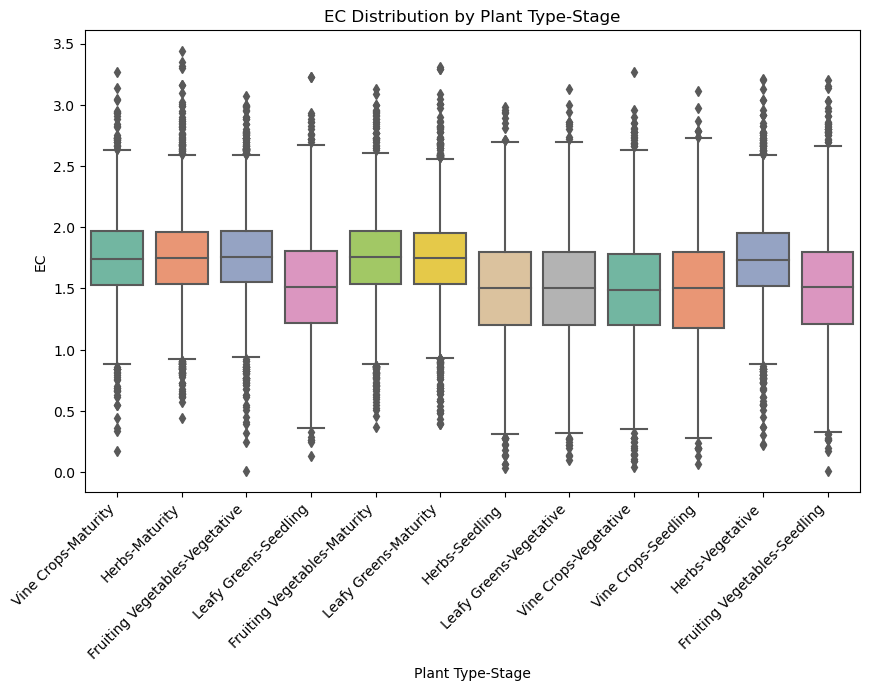

In [39]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Plant Type-Stage', y='EC Sensor (dS/m)', palette='Set2')
plt.title('EC Distribution by Plant Type-Stage')
plt.xlabel('Plant Type-Stage')
plt.ylabel('EC')
plt.xticks(rotation=45, ha='right')
plt.show()

- Investigating outliers in O2:
    - The consistent presence of outliers across zones suggests they may be naturally occurring
    - Notably, the maximum O2 values for the Fruiting Vegetables-Maturity class are significantly higher compared to other classes, contributing to the outliers
    - Similarly, the minimum temperature values for the Leafy Greens-Maturity, Leafy Greens-Vegetative and vine Crops-Vegetative classes are considerably lower than those of other classes, further contributing to the outliers
    - Additional information or domain expertise is required to determine whether these exceptional O2 ranges are valid. Until such confirmation is available, retaining the data is advisable

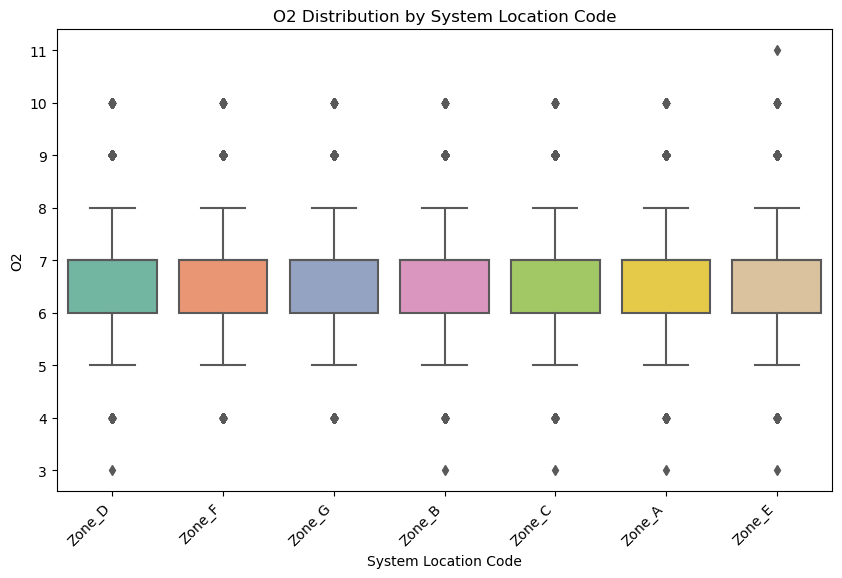

In [40]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='System Location Code', y='O2 Sensor (ppm)', palette='Set2')
plt.title('O2 Distribution by System Location Code')
plt.xlabel('System Location Code')
plt.ylabel('O2')
plt.xticks(rotation=45, ha='right')
plt.show()

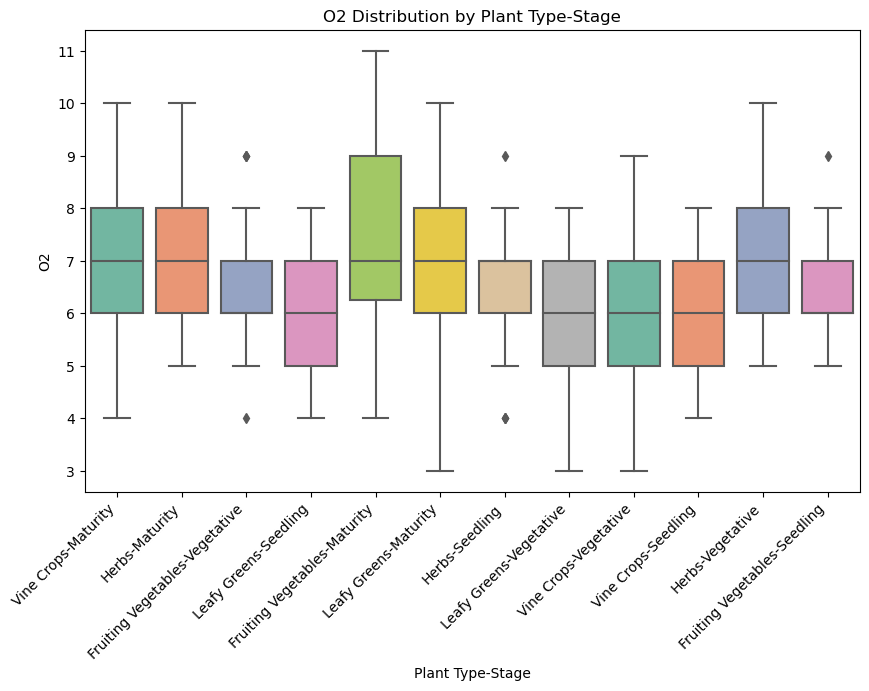

In [41]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Plant Type-Stage', y='O2 Sensor (ppm)', palette='Set2')
plt.title('O2 Distribution by Plant Type-Stage')
plt.xlabel('Plant Type-Stage')
plt.ylabel('O2')
plt.xticks(rotation=45, ha='right')
plt.show()

- Investigating outliers in pH
    - The consistent occurrence of outliers across zones and Plant Type-Stage indicates they are likely naturally occurring and do not warrant removal

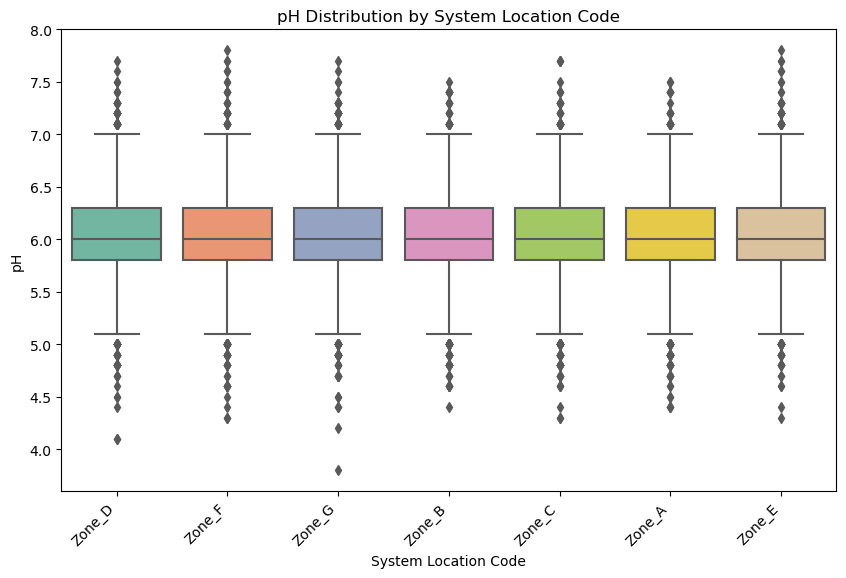

In [42]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='System Location Code', y='pH Sensor', palette='Set2')
plt.title('pH Distribution by System Location Code')
plt.xlabel('System Location Code')
plt.ylabel('pH')
plt.xticks(rotation=45, ha='right')
plt.show()

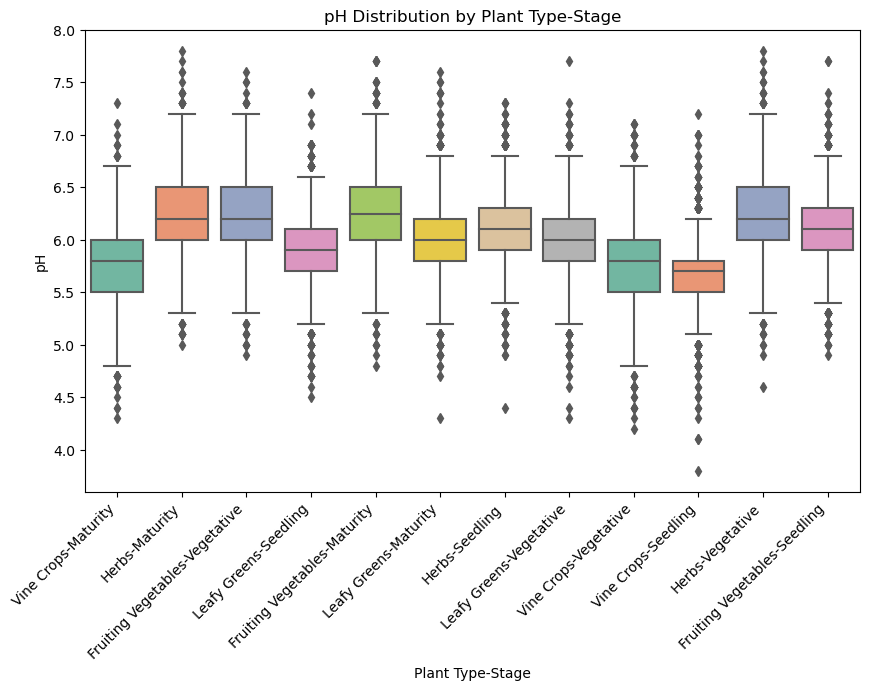

In [43]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Plant Type-Stage', y='pH Sensor', palette='Set2')
plt.title('pH Distribution by Plant Type-Stage')
plt.xlabel('Plant Type-Stage')
plt.ylabel('pH')
plt.xticks(rotation=45, ha='right')
plt.show()

- Investigating outliers in Water Level
    - The consistent occurrence of outliers across zones indicates they are likely naturally occurring and do not warrant removal
    - The boxplots for Plant Type-Stage also suggests that Water Level between 10mm and 40mm is natural for significant number of Plant Type-Stage classes

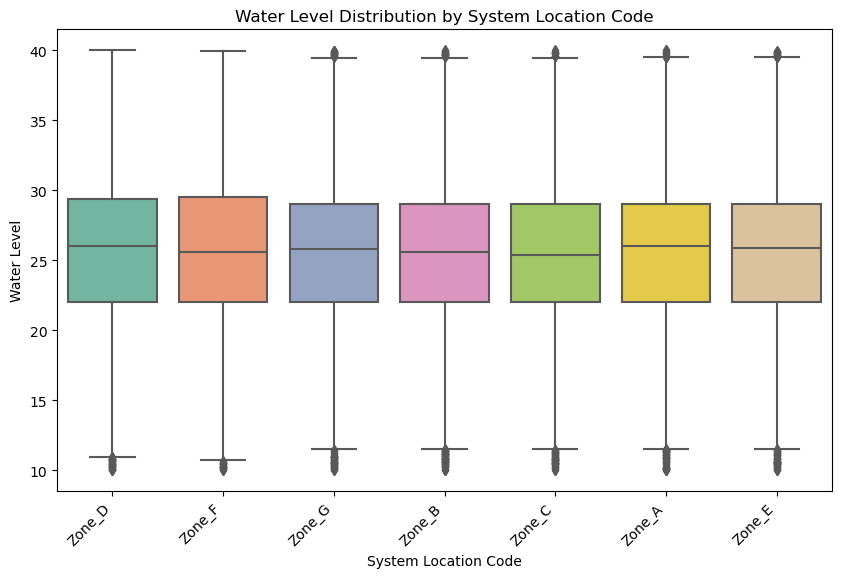

In [44]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='System Location Code', y='Water Level Sensor (mm)', palette='Set2')
plt.title('Water Level Distribution by System Location Code')
plt.xlabel('System Location Code')
plt.ylabel('Water Level')
plt.xticks(rotation=45, ha='right')
plt.show()

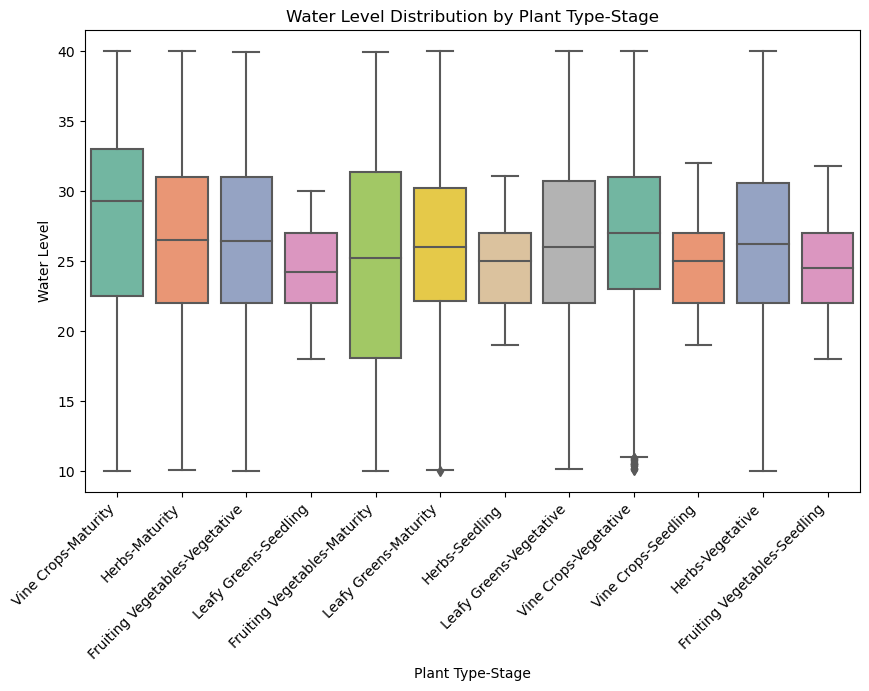

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Plant Type-Stage', y='Water Level Sensor (mm)', palette='Set2')
plt.title('Water Level Distribution by Plant Type-Stage')
plt.xlabel('Plant Type-Stage')
plt.ylabel('Water Level')
plt.xticks(rotation=45, ha='right')
plt.show()

#### Target variable class distribution
- The `value_counts()` method determines the distribution of unique values in Plant Type-Stage
- The distribution of classes is found to be balanced
- A balanced target class distribution helps prevent the model from overfitting to the majority class, thus improving its ability to generalize to unseen data
- In cases of imbalanced class distribution, the model may develop a bias towards the majority class, which can negatively impact its performance on predicting the minority class. Techniques such as resampling, class weighting, or synthetic data generation (e.g., SMOTE) can be applied to mitigate this imbalance and enhance model performance

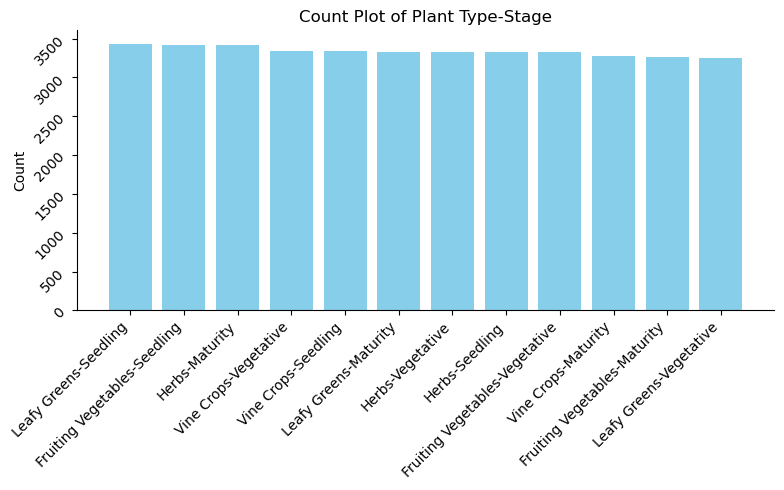

In [46]:
plt.figure(figsize=(8, 5))

column_name = 'Plant Type-Stage'

counts = df[column_name].value_counts()

ax = plt.subplot(1, 1, 1)

ax.bar(counts.index, counts.values, color='skyblue')
ax.set_title(f'Count Plot of {column_name}')
ax.set_ylabel('Count')
ax.tick_params(rotation=45)
ax.set_xticks(counts.index)
ax.set_xticklabels(counts.index, ha='right')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

## Univariate and Bivariate Analysis

#### Plot histograms to visualise distribution of data
- Normal distribution:
    - Ideal for models like linear regression: These models assume features and residuals follow a normal distribution to ensure valid statistical inferences like unbiased coefficients
    - Not required for models like random forest: Random forest do not rely on underlying distributional assumptions. Random Forests work by partitioning the data through decision trees, focusing on splitting the data into regions that maximize predictive accuracy without requiring specific assumptions about the data's distribution
- Skewed distribution:
    - For models like linear regression or logistic regression: Skewed data can lead to biased coefficients, invalid statistical tests, and non-normal residuals, which can affect inference and model accuracy. Data transformations can help reduce skewness and make it closer to a normal distribution
    - For non-parametric models like random forest or gradient boosting: The impact is minimal as they do not make underlying  assumptions about the data but may still be influenced by imbalanced data or extreme outliers, which affects model performance
- Multimodal distribution:
    - For linear models: A multimodal distribution can cause linear models to perform poorly because the relationship between the feature and the target might vary across different modes. Binning or clustering can be used to separate the modes or data transformation can help reduce the impact of large values and pull modes closer together
    - For non-linear models:
        - For tree models like Decsion Trees and Random forest: Tree-based models split data hierarchically, so they can handle multimodal distributions well. However, if the modes are not well-separated, the model might require more splits to accurately capture the structure, leading to overfitting or complexity. Regularization techniques like limiting tree depth, pruning, or boosting methods can help manage complexity
        - For KNN or SVM: These models rely on distances between data points. A multimodal distribution can lead to misleading distances, particularly if the modes are widely separated or clustered tightly. Normalize the data or use clustering to preprocess the features to make distances meaningful
- The `.hist()` method helps to visualise the distribution of numerical data:
    - Normal distributions: Features Temperature, Humidity, EC, pH, and Water Level exhibit approximately normal distributions
    - Skewed distributions: Features Light Intensity, CO2, and O2 appear to be skewed and may require transformation for certain models (e.g. linear regression)
    - Multimodal distribution: Features Nurient N, P, K appear multimodal and require binning to clustering

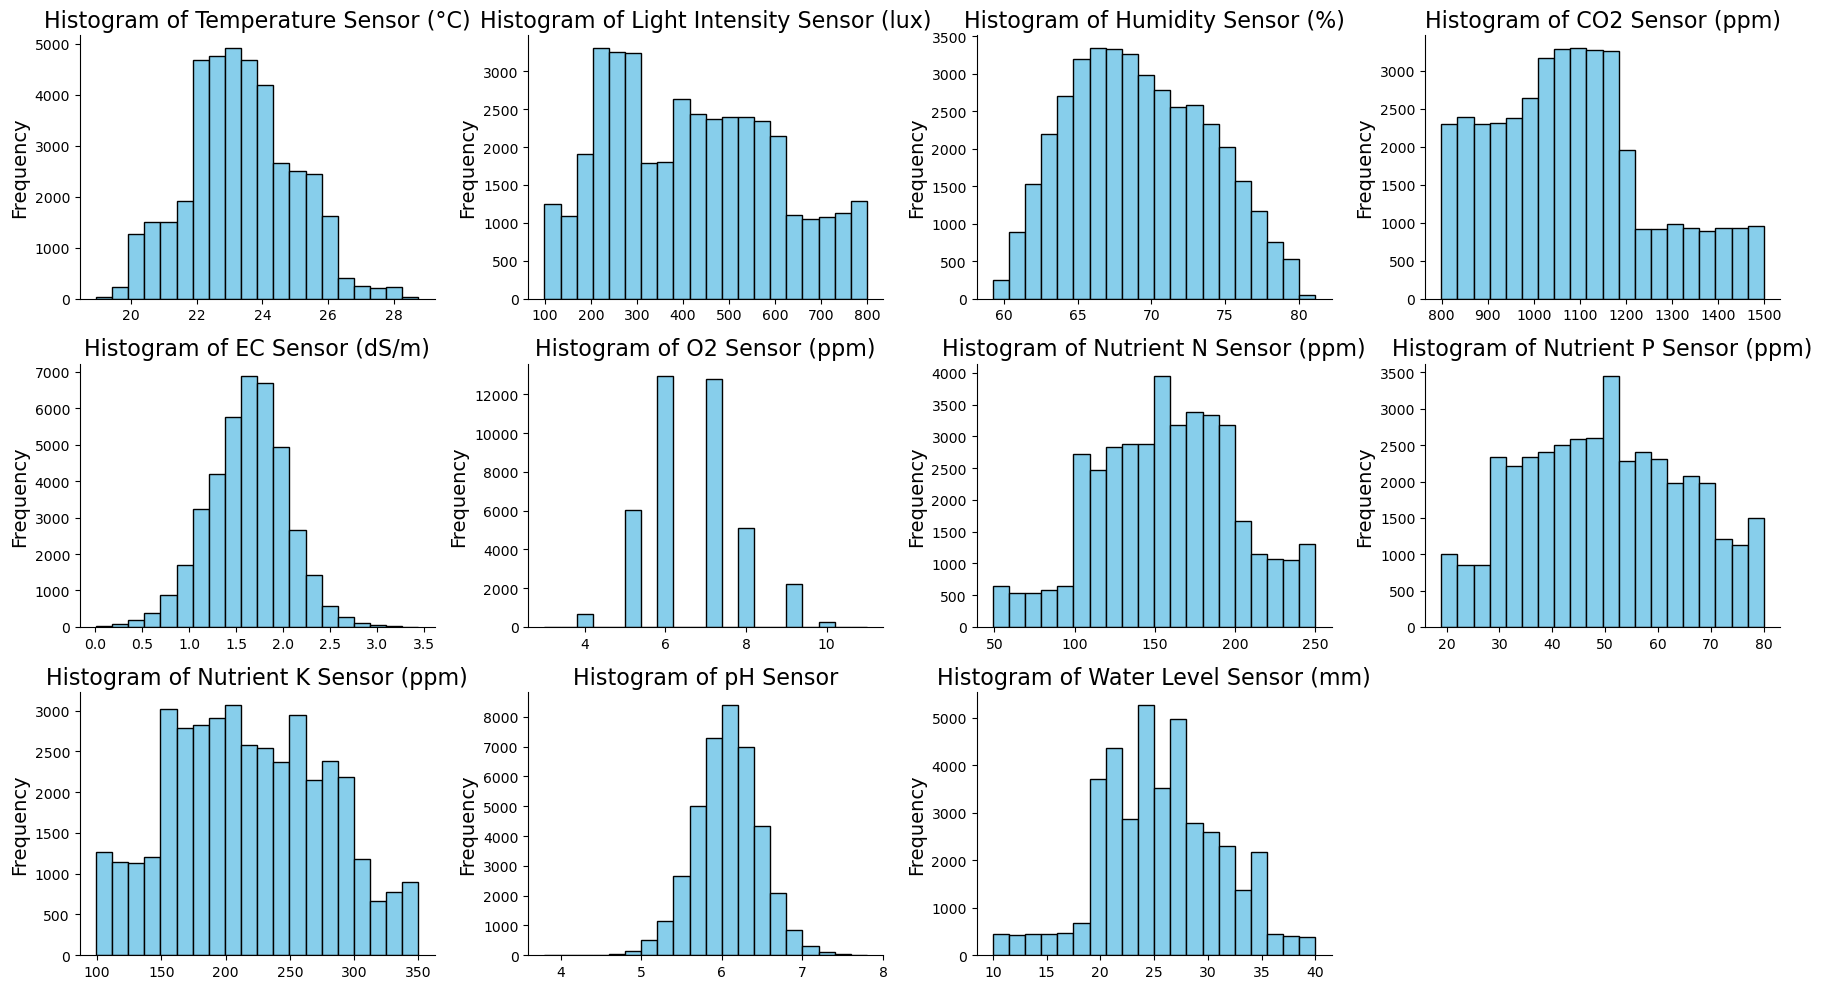

In [47]:
fig, axs = plt.subplots(3, 4, figsize=(18, 10))

axs = axs.flatten()

for i in range(len(num_col)):

    axs[i].hist(df[num_col[i]], bins=20, color='skyblue', edgecolor='black')
    axs[i].set_title(f'Histogram of {num_col[i]}', fontsize=16)
    #axs[i].set_xlabel('Value', fontsize=14)
    axs[i].set_ylabel('Frequency', fontsize=14)
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)

for j in range(len(num_col), len(axs)):
    axs[j].remove()
    
plt.tight_layout()
plt.show()

#### Correlation matrix for numerical variables
- Target correlation:
    - The highest correlation coefficients between the features and the target variable are relatively low, such as 0.29, 0.11, 0.17, 0.14, and -0.22, which suggests a weak relationship between the features and the target variable
    - As correlation is weak, non-linear models like Random Forest, XGBoost, or Gradient Boosting, which are capable of capturing complex relationships beyond linear correlations might be better options
    - Feature transformations (e.g., log, polynomial, interaction terms) can be applied to uncover hidden patterns
- Water Level Sensor:
    - Has weak or no significant correlation with the target (-0.06) and with other features. 
    - For linear models, it might not be useful for prediction and could be removed.
    - For non-linear models, dropping the feature may not be necessary. Feature importance scores from these models can help identify the features that are most impactful for predictions

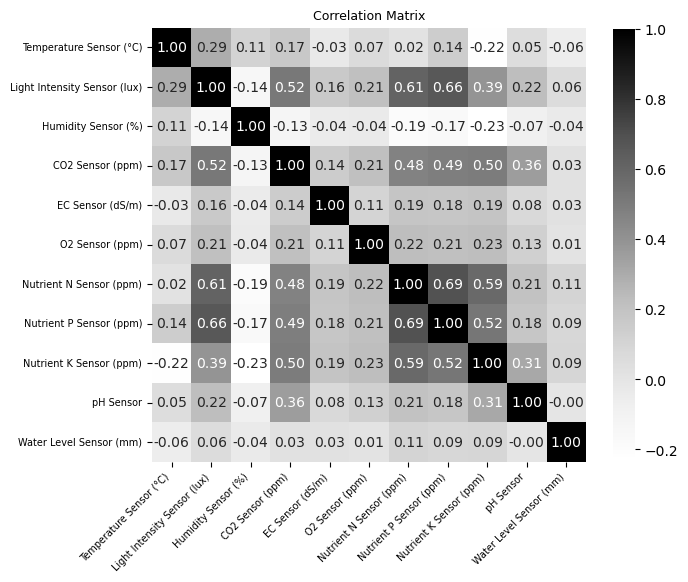

In [48]:
correlation_matrix = df[num_col].corr()
plt.figure(figsize=(7, 7))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='Greys', square=True, cbar_kws={"shrink": .8})

plt.title('Correlation Matrix', fontsize=9)
plt.xticks(rotation=45, fontsize=7, ha='right')
plt.yticks(fontsize=7)
plt.show()

#### Plot bar plots to visualise frequency distribution in categorical variables
- Identify classes that are overrepresented or underrepresented
- Target class imbalance may lead to a biased model towards the majority class
    - This can be addressed using techniques like resampling (oversampling the minority class or undersampling the majority class), assigning class weights during training, or evaluating performance with metrics like F1 score or precision-recall, which account for class imbalance
- Feature class imbalance might result in the model not learning sufficient patterns for underrepresented categories, leading to poor generalization for those classes
- Since the classes are balanced for all features here, the model is expected to learn patterns across all categories effectively, ensuring fair representation of each class during training and better generalization to unseen data

In [49]:
cat_col.append('Plant Type-Stage')

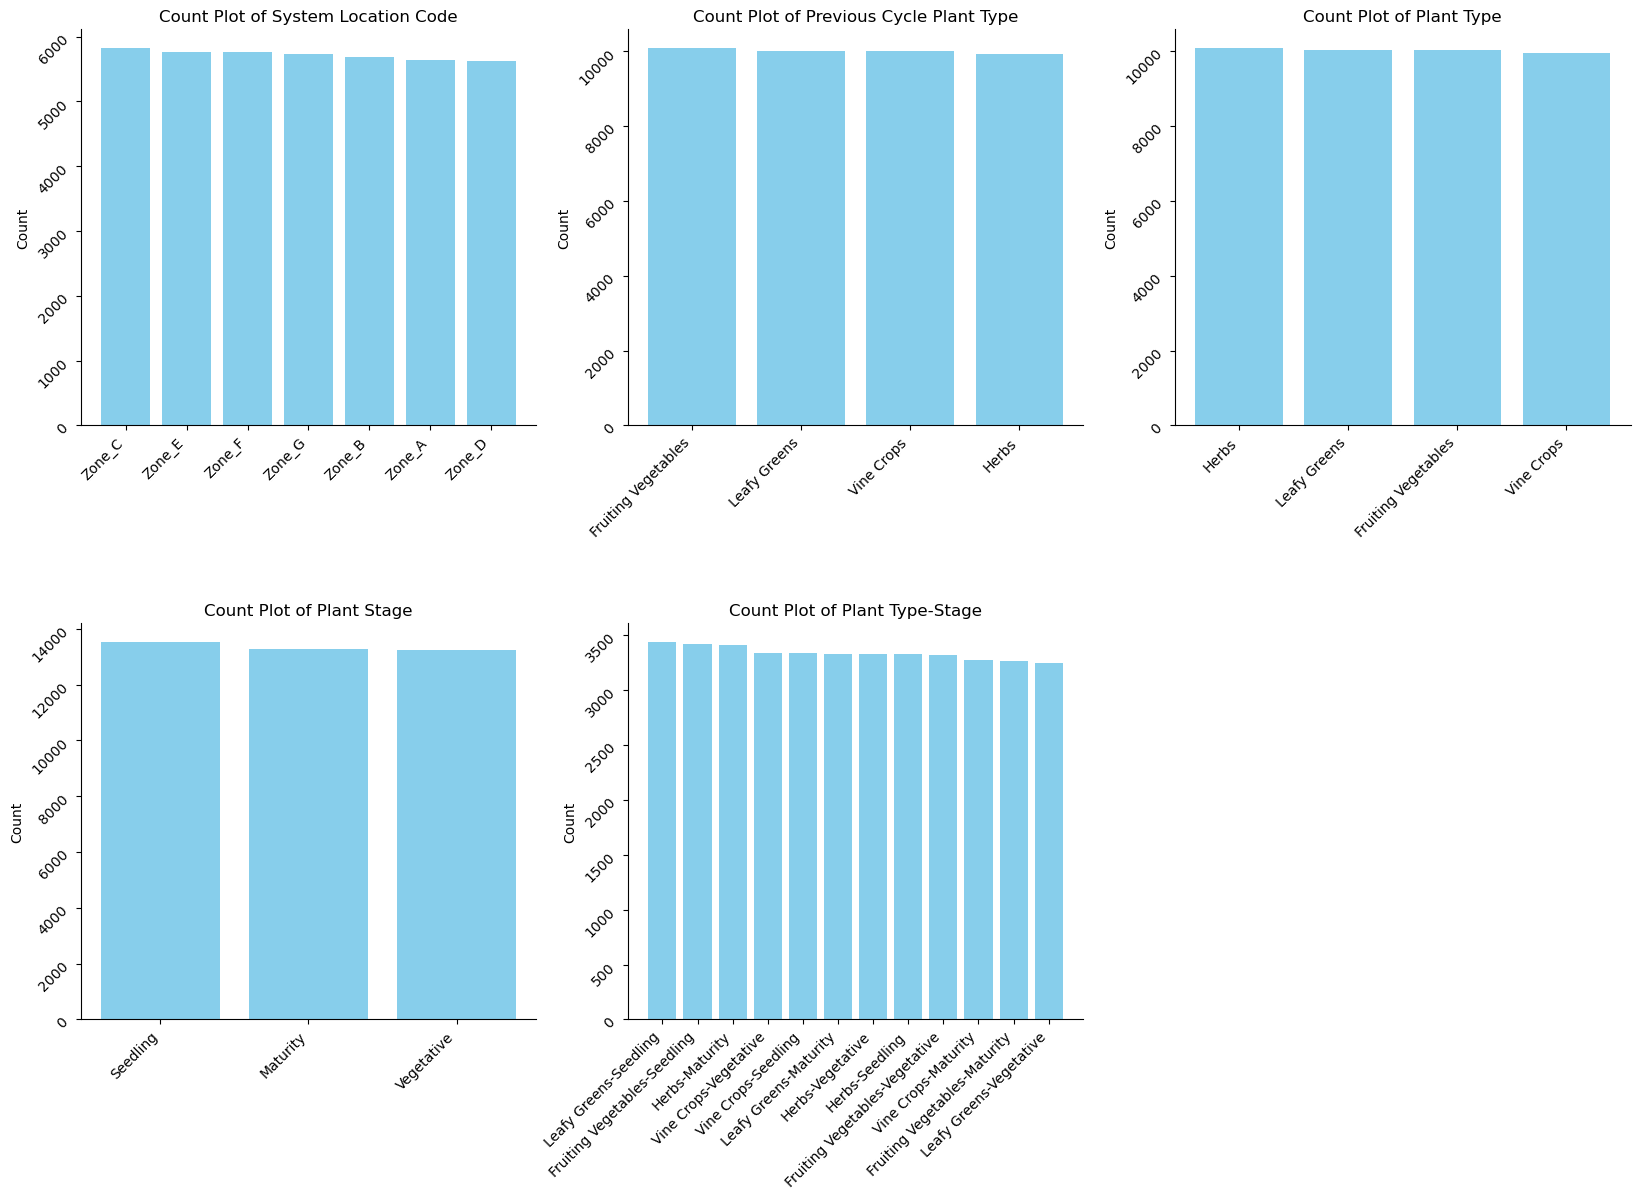

In [50]:
plt.figure(figsize=(20, 36))

for i, column in enumerate(cat_col):
    ax = plt.subplot(5, 3, i + 1)
    
    counts = df[column].value_counts()

    ax.bar(counts.index, counts.values, color='skyblue')
    ax.set_title(f'Count Plot of {column}')
    #ax.set_xlabel(column)
    ax.set_ylabel('Count')
    ax.tick_params(rotation=45)
    ax.set_xticks(range(len(counts.index)))
    ax.set_xticklabels(counts.index, ha='right')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.subplots_adjust(hspace=0.5)
plt.show()

### Feature Engineering

#### One-hot encoding
- to transform categorical variables into a numerical format that models can interpret effectively

In [51]:
df = pd.get_dummies(df, columns=['System Location Code', 'Previous Cycle Plant Type'], drop_first=True)

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['Plant Type-Stage Encoded'] = encoder.fit_transform(df['Plant Type-Stage'])

df.head()

,Plant Type,Plant Stage,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),...,System Location Code_Zone_B,System Location Code_Zone_C,System Location Code_Zone_D,System Location Code_Zone_E,System Location Code_Zone_F,System Location Code_Zone_G,Previous Cycle Plant Type_Herbs,Previous Cycle Plant Type_Leafy Greens,Previous Cycle Plant Type_Vine Crops,Plant Type-Stage Encoded
0,Vine Crops,Maturity,23.34,67.4124,454.0,937,1.82,4,161.0,64.0,...,0,0,1,0,0,0,1,0,0,9
2,Herbs,Maturity,23.84,67.4124,562.0,1246,1.21,8,228.0,79.0,...,0,0,0,0,1,0,1,0,0,3
3,Fruiting Vegetables,Vegetative,22.61,67.4124,651.0,1346,1.96,6,200.2,53.0,...,0,0,0,0,0,1,1,0,0,2
4,Leafy Greens,Seedling,22.88,67.4124,144.0,812,2.76,5,61.0,19.0,...,1,0,0,0,0,0,0,0,1,7
5,Fruiting Vegetables,Maturity,25.96,67.4124,675.0,1338,1.75,8,227.0,53.0,...,0,1,0,0,0,0,0,0,1,0


### Feature Selection

#### Redundant features
- The new combined feature (Plant Type-Stage) already encapsulates the information from plant type and plant stage. Retaining the original features introduces redundant information that does not add value
    - Including highly correlated or derived features in the same model can introduce multicollinearity, which may lead to instability in models like linear regression or logistic regression. Even tree-based models, while less sensitive, might unnecessarily split on redundant features.
- The Plant Type-Stage feature has been encoded, hence retaining it introduces redundant information that does not add value
- Other features that were used for visualisation purposes only such as missing_humidity, temp_bin, etc

In [53]:
df = df.drop(['Plant Type', 'Plant Stage', 'Plant Type-Stage', 
              'missing_humidity', 'temp_bins', 'light_bins',
             'co2_bins', 'ec_bins', 'Plant Type category',
             'Plant Stage category', 'Plant Type-Stage category',
              'System Location Code category'], axis=1)

df.head()

,Temperature Sensor (°C),Humidity Sensor (%),Light Intensity Sensor (lux),CO2 Sensor (ppm),EC Sensor (dS/m),O2 Sensor (ppm),Nutrient N Sensor (ppm),Nutrient P Sensor (ppm),Nutrient K Sensor (ppm),pH Sensor,...,System Location Code_Zone_B,System Location Code_Zone_C,System Location Code_Zone_D,System Location Code_Zone_E,System Location Code_Zone_F,System Location Code_Zone_G,Previous Cycle Plant Type_Herbs,Previous Cycle Plant Type_Leafy Greens,Previous Cycle Plant Type_Vine Crops,Plant Type-Stage Encoded
0,23.34,67.4124,454.0,937,1.82,4,161.0,64.0,201.0,6.1,...,0,0,1,0,0,0,1,0,0,9
2,23.84,67.4124,562.0,1246,1.21,8,228.0,79.0,292.0,6.4,...,0,0,0,0,1,0,1,0,0,3
3,22.61,67.4124,651.0,1346,1.96,6,200.2,53.0,289.0,6.6,...,0,0,0,0,0,1,1,0,0,2
4,22.88,67.4124,144.0,812,2.76,5,61.0,19.0,168.0,5.5,...,1,0,0,0,0,0,0,0,1,7
5,25.96,67.4124,675.0,1338,1.75,8,227.0,53.0,258.0,6.2,...,0,1,0,0,0,0,0,0,1,0


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40029 entries, 0 to 57488
Data columns (total 21 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   Temperature Sensor (°C)                 40029 non-null  float64
 1   Humidity Sensor (%)                     40029 non-null  float64
 2   Light Intensity Sensor (lux)            40029 non-null  float64
 3   CO2 Sensor (ppm)                        40029 non-null  int64  
 4   EC Sensor (dS/m)                        40029 non-null  float64
 5   O2 Sensor (ppm)                         40029 non-null  int64  
 6   Nutrient N Sensor (ppm)                 40029 non-null  float64
 7   Nutrient P Sensor (ppm)                 40029 non-null  float64
 8   Nutrient K Sensor (ppm)                 40029 non-null  float64
 9   pH Sensor                               40029 non-null  float64
 10  Water Level Sensor (mm)                 40029 non-null  fl

## Model Selection

#### Insights for regression
1. The correlation matrix reveals that the highest correlation coefficients between the features and the target variable are relatively low (e.g., 0.29, 0.11, 0.17, 0.14, and -0.22), indicating weak linear relationships. As a result, linear regression may not perform well in this scenario
2. The histogram shows the presence of multimodal distributions. Polynomial regression may not perform well in this scenario as the polynomial functions tend to try to fit all the peaks with a single curve. This results in an overly smoothed approximation of the true underlying distribution
3. For this scenario, more flexible models like random forests, gradient boosting, or kernel-based SVR tend to manage multimodal distributions more effectively.

#### Insights for classification
1. Frequency distributions shows balanced feature and target classes, hence there is no need to use techniques like resampling or class weighting techniques to reduce bias to any one class
2. The histogram shows not all features follow a normal distribution. Models like Logistic regression and Naive Bayes may perform poorly when the data doesn’t follow normal or linear distributions because of their inherent assumptions
3. For this scenario, more flexible models like tree-based, bagging-based ensemble and boosting-based ensemble methods tend to handle features that do not follow a normal distrition more effectively